In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# **Step 1: Define File Path**
file_path = r"D:\Pipeline RUL Data\Processed\Sensor_Channel_1.mat"

# **Step 2: Open `.mat` File (HDF5 Format)**
with h5py.File(file_path, "r") as matfile:
    print("🔹 Available Keys in the File:", list(matfile.keys()))  # Check dataset names

    # **Step 3: Read Data**
    data = np.array(matfile["Channel_1"])  # Read the dataset

    # **Step 4: Display Summary**
    print(f"✅ Data Shape: {data.shape}")
    print(f"✅ Mean: {np.mean(data)}, Std Dev: {np.std(data)}")
    print(f"✅ Min: {np.min(data)}, Max: {np.max(data)}")

# **Step 5: Plot First 1000 Samples**
plt.figure(figsize=(10, 4))
plt.plot(data[:1000])
plt.title("First 1000 Samples - Sensor Channel 1")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(data[:2000])  # Plot more samples
plt.title("Zoomed-in View: First 2000 Samples - Sensor Channel 1")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


In [ ]:
import numpy as np
import h5py
import os

# **Step 1: Define File Paths**
file_path = r"D:\Pipeline RUL Data\Test20190731-104527-983.wfs"
output_folder = r"D:\Pipeline RUL Data\Processed"  # Save each channel separately

header_size = 4096  # Skip metadata
num_channels = 8
bytes_per_sample = 2

# **Step 2: Compute Total Samples**
file_size = os.path.getsize(file_path)
total_samples = (file_size - header_size) // (num_channels * bytes_per_sample)

print(f"Total Samples (per channel): {total_samples}")

# **Step 3: Read the `.wfs` File Efficiently Using `memmap`**
data = np.memmap(file_path, dtype=np.int16, mode='r', offset=header_size)

In [ ]:
from scipy.signal import hilbert

analytic_signal = hilbert(data[:150000])
envelope = np.abs(analytic_signal)

plt.figure(figsize=(10, 4))
plt.plot(data[:150000], label="Raw AE Signal", alpha=0.9)
plt.plot(envelope, label="Envelope", linewidth=1)
#plt.title("Envelope of AE Signal (Hilbert Transform)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
#plt.grid()
plt.show()


In [ ]:
threshold = 3000  # Set based on observed spikes
ae_hits = np.where(data[:150000] > threshold)[0]

print(f"🔹 AE Hits Detected at Samples: {ae_hits}")


In [ ]:
from scipy.signal import spectrogram

fs = 1_000_000  # 1 MHz sampling rate
f, t, Sxx = spectrogram(data[:150000], fs, nperseg=256)

plt.figure(figsize=(10, 4))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.title("Spectrogram of AE Signal")
plt.colorbar(label="Power (dB)")
plt.show()


In [1]:
# ============================================================================
# CELL 1: Imports & Basic Config
# ============================================================================

import os, re, glob, math, gc, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Nice plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


✅ Imports successful!
PyTorch version: 2.8.0+cu126
CUDA available: True


In [2]:
# ============================================================================
# CELL 2: Global Settings & Hyperparameters
# ============================================================================

# ========= DATASET CONFIG =========
BASE = r"E:\Collaboration Work\With Farooq\phm dataset\PHM Challange 2010 Milling"
TRAIN_CUTTERS = ["c1", "c4", "c6"]
TEST_CUTTERS  = ["c2", "c3", "c5"]

# Raw signal windowing
WIN = 4096
HOP = 2048
MAX_WINDOWS = 96      # max windows per cut
SAMPLING_RATE = 50000

# ========= PHYSICS PARAMETERS (Taylor-like) =========
TAYLOR_PARAMS = {
    'C': 1e-8,
    'alpha': 0.13,
    'beta': 0.77,
    'gamma': 0.37,
    'delta': 0.5
}

# ========= MODEL ARCHITECTURE =========
FEAT_DIM = 18 * 7        # (time+freq) per channel * 7 channels = 126
WINDOW_HIDDEN_DIM = 128  # LSTM for windows within a cut
CUT_STATE_DIM = 64       # embedding per cut
DEGRAD_HIDDEN_DIM = 128  # RNN for degradation across cuts
LATENT_DAMAGE_DIM = 1    # z_k scalar per cut
SHARED_HIDDEN_DIM = 128
DROPOUT = 0.3

# ========= SEQUENCE-LEVEL SETTINGS =========
SEQ_LEN_CUTS = 20   # number of cuts per training sequence (can tune)
STRIDE_CUTS = 5     # stride when sliding over cuts

# ========= TRAINING =========
LR = 1e-3
EPOCHS = 120
BATCH_SIZE = 8
VAL_RATIO = 0.2
SEED = 42

# ========= LOSS WEIGHTS =========
MTL_WEIGHTS = {
    'f1':   0.2,
    'f2':   0.2,
    'f3':   0.2,
    'wear': 1.0,
    'rul':  1.2,
}

LAMBDA_LATENT_PHYSICS   = 0.5    # physics on latent damage z
LAMBDA_OUTPUT_MONO      = 0.4    # monotonic wear prediction
LAMBDA_LATENT_MONO      = 0.3    # monotonic latent damage
LAMBDA_UNCERTAINTY      = 0.2    # aleatoric (logvar) loss

# ========= REPRODUCIBILITY =========
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.set_default_dtype(torch.float32)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\n" + "="*60)
print(f"🖥️ Device: {device}")
print(f"📊 Dataset: PHM Challenge 2010 Milling")
print(f"🔬 Model: Physics-Guided Latent Damage State-Space RUL")
print("="*60 + "\n")



🖥️ Device: cuda
📊 Dataset: PHM Challenge 2010 Milling
🔬 Model: Physics-Guided Latent Damage State-Space RUL



In [3]:
# ============================================================================
# CELL 3: Wear Table & Cut File Discovery
# ============================================================================

def read_wear_table(cutter_dir):
    cands = [p for p in glob.glob(os.path.join(cutter_dir, "*.csv"))
             if "wear" in os.path.basename(p).lower()]
    if not cands:
        raise FileNotFoundError(f"No wear csv in {cutter_dir}")
    wear_file = cands[0]

    raw0 = pd.read_csv(wear_file, sep=None, engine="python", nrows=5)
    try:
        v = pd.to_numeric(raw0.iloc[0, 0], errors="coerce")
        use_header = bool(pd.isna(v))
    except Exception:
        use_header = True

    raw = (pd.read_csv(wear_file, sep=None, engine="python")
           if use_header else
           pd.read_csv(wear_file, sep=None, engine="python", header=None))
    raw.columns = [str(c).strip().lower() for c in raw.columns]

    def first_present(names):
        for n in names:
            if n in raw.columns:
                return n
        return None

    cut_col = first_present(["cut", "cut_number", "cut no", "cut_no", "c", "index", "id", "0"])
    f1_col  = first_present(["flute_1", "flute1", "f1", "flute 1", "1"])
    f2_col  = first_present(["flute_2", "flute2", "f2", "flute 2", "2"])
    f3_col  = first_present(["flute_3", "flute3", "f3", "flute 3", "3"])

    if cut_col is None or f1_col is None or f2_col is None or f3_col is None:
        tmp = raw.copy().dropna(axis=1, how="all")
        assert tmp.shape[1] >= 4, "Wear file must have >=4 usable columns"
        tmp.columns = [f"col_{i}" for i in range(tmp.shape[1])]
        cut_col, f1_col, f2_col, f3_col = "col_0", "col_1", "col_2", "col_3"
        raw = tmp

    cut_series = raw[cut_col].astype(str).str.extract(r"(\d+)", expand=False)
    cut_series = pd.to_numeric(cut_series, errors="coerce")

    f1 = pd.to_numeric(raw[f1_col], errors="coerce")
    f2 = pd.to_numeric(raw[f2_col], errors="coerce")
    f3 = pd.to_numeric(raw[f3_col], errors="coerce")

    df = pd.DataFrame({
        "Cut_Number": cut_series,
        "flute_1": f1,
        "flute_2": f2,
        "flute_3": f3
    }).dropna()
    df["Cut_Number"] = df["Cut_Number"].round().astype(int)

    df["wear_max"] = df[["flute_1", "flute_2", "flute_3"]].max(axis=1)
    EOL = float(df["wear_max"].max())

    eps = 1e-9
    df["f1_norm"] = df["flute_1"] / (EOL + eps)
    df["f2_norm"] = df["flute_2"] / (EOL + eps)
    df["f3_norm"] = df["flute_3"] / (EOL + eps)
    df["wear_norm"] = df["wear_max"] / (EOL + eps)
    df["rul_norm"] = 1.0 - df["wear_norm"]
    df["RUL"] = EOL - df["wear_max"]

    return df.sort_values("Cut_Number").reset_index(drop=True), EOL


def discover_cut_files(cutter_dir, cutter_id):
    all_csvs = glob.glob(os.path.join(cutter_dir, "**", "*.csv"), recursive=True)
    all_csvs = [p for p in all_csvs if "wear" not in os.path.basename(p).lower()]
    cuts = {}
    for p in all_csvs:
        name = os.path.basename(p).lower()
        m = (re.search(rf"c[_-]?{cutter_id}[_-]?(\d+)\.csv$", name) or
             re.search(r"(\d+)\.csv$", name))
        if m:
            cuts[int(m.group(1))] = p
    return dict(sorted(cuts.items()))


def extract_cutting_parameters(cut_number, cutter_name):
    # For now, keep them fixed like your original (can extend later)
    spindle_speed = 10400
    feed_rate = 1555
    tool_diameter = 12.0  # mm
    cutting_speed = (math.pi * tool_diameter * spindle_speed) / 1000.0  # m/min
    depth_of_cut = 0.5     # mm
    cumulative_time = float(cut_number)  # proxy for time/load

    return {
        'V': cutting_speed,
        'f': feed_rate / 1000.0,
        'd': depth_of_cut,
        't': cumulative_time,
        'cutter': cutter_name
    }

print("✅ Wear table & cut discovery utilities ready!")


✅ Wear table & cut discovery utilities ready!


In [4]:
# ============================================================================
# CELL 4: Advanced Feature Extraction (Per Window & Per Cut)
# ============================================================================

def extract_time_domain_features(x):
    if x.size == 0:
        return np.zeros(10, dtype=np.float32)

    mean = float(np.mean(x))
    std = float(np.std(x))
    rms = float(np.sqrt(np.mean(x**2)))
    peak = float(np.max(np.abs(x)))

    if std > 1e-9:
        skewness = float(np.mean(((x - mean) / std)**3))
        kurtosis = float(np.mean(((x - mean) / std)**4))
    else:
        skewness = 0.0
        kurtosis = 0.0

    crest_factor   = peak / (rms + 1e-9)
    impulse_factor = peak / (np.mean(np.abs(x)) + 1e-9)
    peak_to_peak   = float(np.ptp(x))
    energy         = float(np.sum(x**2))

    return np.array([mean, std, rms, peak,
                     crest_factor, skewness, kurtosis,
                     impulse_factor, peak_to_peak, energy],
                    dtype=np.float32)


def extract_frequency_domain_features(x, fs=SAMPLING_RATE):
    if x.size == 0:
        return np.zeros(8, dtype=np.float32)

    X = np.fft.rfft(x, n=len(x))
    P = np.abs(X)**2
    freqs = np.fft.rfftfreq(len(x), d=1.0/fs)

    total_power = float(P.sum())
    if total_power < 1e-12:
        return np.zeros(8, dtype=np.float32)

    centroid = float((freqs * P).sum() / total_power)
    spread   = float(np.sqrt(((freqs - centroid)**2 * P).sum() / total_power))
    spec_skew = float((((freqs - centroid)**3 * P).sum() / total_power) / (spread**3 + 1e-9))
    spec_kurt = float((((freqs - centroid)**4 * P).sum() / total_power) / (spread**4 + 1e-9))

    low_band  = P[(freqs >= 0) & (freqs < 5000)].sum()
    mid_band  = P[(freqs >= 5000) & (freqs < 15000)].sum()
    high_band = P[(freqs >= 15000) & (freqs < 25000)].sum()

    low_ratio  = float(low_band  / (total_power + 1e-9))
    mid_ratio  = float(mid_band  / (total_power + 1e-9))
    high_ratio = float(high_band / (total_power + 1e-9))

    return np.array([total_power, centroid, spread, spec_skew, spec_kurt,
                     low_ratio, mid_ratio, high_ratio], dtype=np.float32)


def extract_window_features(x, fs=SAMPLING_RATE):
    time_feats = extract_time_domain_features(x)
    freq_feats = extract_frequency_domain_features(x, fs)
    return np.concatenate([time_feats, freq_feats], axis=0)


def extract_cut_windows(path, win=WIN, hop=HOP, max_windows=MAX_WINDOWS):
    try:
        df = pd.read_csv(path, header=None, engine="c", low_memory=False)
    except Exception:
        df = pd.read_csv(path, header=None, engine="python", low_memory=False)

    df = df.dropna(axis=1, how="all")
    if df.shape[1] < 7:
        return None

    arr = df.iloc[:, :7].to_numpy(dtype=np.float32, copy=False)
    N = arr.shape[0]
    feats = []

    if N >= win:
        for start in range(0, N - win + 1, hop):
            seg = arr[start:start+win, :]
            window_feat = []
            for ch in range(7):
                ch_feat = extract_window_features(seg[:, ch])
                window_feat.append(ch_feat)
            feats.append(np.concatenate(window_feat, axis=0))
            if len(feats) >= max_windows:
                break
    else:
        seg = arr
        window_feat = []
        for ch in range(7):
            ch_feat = extract_window_features(seg[:, ch])
            window_feat.append(ch_feat)
        feats.append(np.concatenate(window_feat, axis=0))

    Fmat = np.stack(feats, axis=0)  # [T_win, 126]
    T = Fmat.shape[0]

    if T < max_windows:
        pad = np.zeros((max_windows - T, Fmat.shape[1]), dtype=np.float32)
        Fmat = np.concatenate([Fmat, pad], axis=0)
    else:
        Fmat = Fmat[:max_windows]
        T = max_windows

    return Fmat, T

print("✅ Feature extraction ready (126 features/window).")


✅ Feature extraction ready (126 features/window).


In [5]:
# ============================================================================
# CELL 5: Build Per-Cut Index
# ============================================================================

def build_index_for_cutters(cutters, labeled=True):
    index = []
    eol_map = {}
    
    for cname in cutters:
        cutter_dir = os.path.join(BASE, cname)
        cutter_id = int(re.findall(r"\d+", cname)[0])
        cut_files = discover_cut_files(cutter_dir, cutter_id)

        if labeled:
            wear_df, EOL = read_wear_table(cutter_dir)
            eol_map[cname] = EOL

            present = sorted(set(wear_df["Cut_Number"].astype(int)).intersection(cut_files.keys()))
            for cutn in present:
                row = wear_df.loc[wear_df["Cut_Number"] == cutn].iloc[0]
                y_norm = np.array([row["f1_norm"], row["f2_norm"], row["f3_norm"],
                                   row["wear_norm"], row["rul_norm"]], dtype=np.float32)
                y_raw  = np.array([row["flute_1"], row["flute_2"], row["flute_3"],
                                   row["wear_max"], row["RUL"]], dtype=np.float32)
                cut_params = extract_cutting_parameters(cutn, cname)

                index.append({
                    "cutter": cname,
                    "eol": EOL,
                    "cut_number": int(cutn),
                    "path": cut_files[int(cutn)],
                    "y_norm": y_norm,
                    "y_raw": y_raw,
                    "cutting_params": cut_params
                })
        else:
            present = sorted(cut_files.keys())
            for cutn in present:
                cut_params = extract_cutting_parameters(cutn, cname)
                index.append({
                    "cutter": cname,
                    "eol": None,
                    "cut_number": int(cutn),
                    "path": cut_files[int(cutn)],
                    "y_norm": None,
                    "y_raw": None,
                    "cutting_params": cut_params
                })

    return index, eol_map


train_index, train_eols = build_index_for_cutters(TRAIN_CUTTERS, labeled=True)
test_index, _ = build_index_for_cutters(TEST_CUTTERS, labeled=False)

print("\n📊 Dataset Summary:")
print("="*60)
print(f"Train cuts: {len(train_index)}")
print(f"Test cuts:  {len(test_index)}")
print("\n🔧 Train EOLs:")
for k, v in train_eols.items():
    print(f"   {k}: {v:.2f}")
EOL_REF = float(np.median(list(train_eols.values())))
print(f"\n📐 Median EOL Reference: {EOL_REF:.2f}")
print("="*60 + "\n")



📊 Dataset Summary:
Train cuts: 945
Test cuts:  945

🔧 Train EOLs:
   c1: 172.69
   c4: 210.92
   c6: 234.72

📐 Median EOL Reference: 210.92



In [6]:
# ============================================================================
# CELL 6: Physics Model (Taylor) & Loss Utilities
# ============================================================================

class TaylorWearModel:
    def __init__(self, params=TAYLOR_PARAMS):
        self.C = params['C']
        self.alpha = params['alpha']
        self.beta = params['beta']
        self.gamma = params['gamma']
        self.delta = params['delta']

    def predict_wear(self, V, f, d, t):
        # V, f, d, t are torch tensors with same shape
        return self.C * (V ** self.alpha) * (f ** self.beta) * (d ** self.gamma) * (t ** self.delta)


taylor_model = TaylorWearModel(TAYLOR_PARAMS)
print("✅ Taylor wear model ready!")


✅ Taylor wear model ready!


In [7]:
# ============================================================================
# CELL 7: Precompute Cut Features & Fit Scaler
# ============================================================================

def precompute_cut_features(all_index):
    """
    Precompute window features for every (cutter, cut_number).
    Returns:
      features_dict[(cutter, cut_number)] = np.array [MAX_WINDOWS, FEAT_DIM]
      lengths_dict[(cutter, cut_number)]  = int (valid windows)
    """
    features_dict = {}
    lengths_dict = {}
    for it in tqdm(all_index, desc="Precomputing cut features"):
        key = (it["cutter"], it["cut_number"])
        if key in features_dict:
            continue
        out = extract_cut_windows(it["path"])
        if out is None:
            X = np.zeros((MAX_WINDOWS, FEAT_DIM), dtype=np.float32)
            L = 1
        else:
            X, L = out
        features_dict[key] = X
        lengths_dict[key] = int(L)
    return features_dict, lengths_dict


# Precompute for train + test
all_index = train_index + test_index
features_dict, lengths_dict = precompute_cut_features(all_index)

# Fit scaler on all TRAIN windows only
all_train_windows = []
for it in train_index:
    key = (it["cutter"], it["cut_number"])
    X = features_dict[key]
    L = lengths_dict[key]
    all_train_windows.append(X[:L])
all_train_windows = np.concatenate(all_train_windows, axis=0)
print(f"Scaler fit on {all_train_windows.shape[0]} windows.")

scaler = StandardScaler().fit(all_train_windows)

# Apply scaler to ALL cuts (train & test)
for key in tqdm(features_dict.keys(), desc="Scaling cut features"):
    X = features_dict[key]
    X_scaled = scaler.transform(X).astype(np.float32)
    features_dict[key] = X_scaled

print("✅ Precomputation & scaling done!")


Precomputing cut features: 100%|██████████| 1890/1890 [16:02<00:00,  1.96it/s]


Scaler fit on 90647 windows.


Scaling cut features: 100%|██████████| 1890/1890 [00:00<00:00, 4760.44it/s]

✅ Precomputation & scaling done!


In [8]:
# ============================================================================
# CELL 8: Cutter-Level Sequence Dataset
# ============================================================================

class CutterSequenceDataset(Dataset):
    """
    Each item is a sequence of cuts for a single cutter:
      - X_seq: [S_cuts, MAX_WINDOWS, FEAT_DIM]
      - win_lengths: [S_cuts]
      - cut_params: [S_cuts, 4] (V,f,d,t)
      - y_norm: [S_cuts, 5] (NaN for unlabeled)
      - eol: scalar (NaN for unlabeled/test)
    """
    def __init__(self, index, features_dict, lengths_dict,
                 seq_len_cuts=SEQ_LEN_CUTS, stride_cuts=STRIDE_CUTS,
                 labeled=True):
        super().__init__()
        self.index = index
        self.features_dict = features_dict
        self.lengths_dict = lengths_dict
        self.seq_len_cuts = seq_len_cuts
        self.stride_cuts = stride_cuts
        self.labeled = labeled

        # Group cuts by cutter
        cutter_to_cuts = {}
        cutter_to_items = {}
        for it in index:
            c = it["cutter"]
            if c not in cutter_to_cuts:
                cutter_to_cuts[c] = []
                cutter_to_items[c] = {}
            cutter_to_cuts[c].append(it["cut_number"])
            cutter_to_items[c][it["cut_number"]] = it

        for c in cutter_to_cuts:
            cutter_to_cuts[c] = sorted(cutter_to_cuts[c])

        # Build sequence list: (cutter, list_of_cut_numbers)
        self.samples = []
        for cutter, cut_list in cutter_to_cuts.items():
            N = len(cut_list)
            if N == 0:
                continue

            if N <= seq_len_cuts:
                # one sequence containing all cuts
                self.samples.append((cutter, cut_list))
            else:
                # sliding window over cuts
                start = 0
                while True:
                    end = start + seq_len_cuts
                    if end >= N:
                        # last window includes final cuts
                        seq_cuts = cut_list[-seq_len_cuts:]
                        self.samples.append((cutter, seq_cuts))
                        break
                    seq_cuts = cut_list[start:end]
                    self.samples.append((cutter, seq_cuts))
                    start += stride_cuts

        self.cutter_to_items = cutter_to_items

        print(f"✅ CutterSequenceDataset created: {len(self.samples)} sequences "
              f"from {len(cutter_to_cuts)} cutters.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        cutter, cut_numbers = self.samples[idx]
        items_map = self.cutter_to_items[cutter]

        S = len(cut_numbers)
        X_seq = np.zeros((S, MAX_WINDOWS, FEAT_DIM), dtype=np.float32)
        win_lengths = np.zeros((S,), dtype=np.int64)
        cut_params_arr = np.zeros((S, 4), dtype=np.float32)
        y_norm_arr = np.full((S, 5), np.nan, dtype=np.float32)

        # EOL is constant per cutter (for train cutters)
        first_item = items_map[cut_numbers[0]]
        eol_val = float(first_item["eol"]) if first_item["eol"] is not None else np.nan

        for i, cutn in enumerate(cut_numbers):
            it = items_map[cutn]
            key = (cutter, cutn)
            X = self.features_dict[key]
            L = self.lengths_dict[key]
            X_seq[i] = X
            win_lengths[i] = max(int(L), 1)

            cp = it["cutting_params"]
            cut_params_arr[i] = np.array([cp["V"], cp["f"], cp["d"], cp["t"]], dtype=np.float32)

            if self.labeled and it["y_norm"] is not None:
                y_norm_arr[i] = it["y_norm"]
            else:
                # leave as NaN
                pass

        return (
            torch.from_numpy(X_seq),          # [S, T, F]
            torch.from_numpy(win_lengths),    # [S]
            torch.from_numpy(cut_params_arr), # [S, 4]
            torch.from_numpy(y_norm_arr),     # [S, 5]
            torch.tensor(eol_val, dtype=torch.float32),
            np.array(cut_numbers, dtype=int),
            cutter
        )


def collate_cutter_sequences(batch):
    """
    Pad sequences of cuts to same S_max within batch.
    Returns:
      X_batch: [B, S_max, T, F]
      win_lengths: [B, S_max]
      cut_params: [B, S_max, 4]
      y_norm: [B, S_max, 5]
      eol: [B]
      seq_lengths: [B]
      seq_mask: [B, S_max] (True where valid cut)
      cut_numbers_list: list of np arrays
      cutter_list: list of strings
    """
    X_list, wlen_list, cp_list, y_list, eol_list, cutn_list, cutter_list = zip(*batch)

    B = len(X_list)
    S_lengths = [x.shape[0] for x in X_list]
    S_max = max(S_lengths)
    T = X_list[0].shape[1]
    Fdim = X_list[0].shape[2]

    X_batch = torch.zeros((B, S_max, T, Fdim), dtype=torch.float32)
    win_lengths = torch.zeros((B, S_max), dtype=torch.long)
    cut_params = torch.zeros((B, S_max, 4), dtype=torch.float32)
    y_norm = torch.full((B, S_max, 5), float("nan"), dtype=torch.float32)
    seq_mask = torch.zeros((B, S_max), dtype=torch.bool)
    seq_lengths = torch.tensor(S_lengths, dtype=torch.long)
    eol = torch.stack(eol_list)

    for i in range(B):
        S = S_lengths[i]
        X_batch[i, :S] = X_list[i]
        win_lengths[i, :S] = wlen_list[i]
        cut_params[i, :S] = cp_list[i]
        y_norm[i, :S] = y_list[i]
        seq_mask[i, :S] = True

    return (
        X_batch, win_lengths, cut_params, y_norm,
        eol, seq_lengths, seq_mask,
        cutn_list, cutter_list
    )


print("✅ Cutter-level sequence dataset & collate_fn ready!")


✅ Cutter-level sequence dataset & collate_fn ready!


In [9]:
# ============================================================================
# CELL 9: Build Datasets & Dataloaders
# ============================================================================

# Split train_index into train/val at the cutter-sequence level
full_train_ds = CutterSequenceDataset(
    train_index, features_dict, lengths_dict,
    seq_len_cuts=SEQ_LEN_CUTS, stride_cuts=STRIDE_CUTS, labeled=True
)

val_n = int(len(full_train_ds) * VAL_RATIO)
train_n = len(full_train_ds) - val_n

train_ds, val_ds = torch.utils.data.random_split(
    full_train_ds,
    [train_n, val_n],
    generator=torch.Generator().manual_seed(SEED)
)

test_ds = CutterSequenceDataset(
    test_index, features_dict, lengths_dict,
    seq_len_cuts=SEQ_LEN_CUTS, stride_cuts=STRIDE_CUTS, labeled=False
)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=0, collate_fn=collate_cutter_sequences,
    pin_memory=torch.cuda.is_available()
)

val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=0, collate_fn=collate_cutter_sequences,
    pin_memory=torch.cuda.is_available()
)

test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=0, collate_fn=collate_cutter_sequences,
    pin_memory=torch.cuda.is_available()
)

print("\n📦 Datasets:")
print("="*60)
print(f"Train sequences: {len(train_ds)}")
print(f"Val   sequences: {len(val_ds)}")
print(f"Test  sequences: {len(test_ds)}")
print("="*60 + "\n")


✅ CutterSequenceDataset created: 180 sequences from 3 cutters.
✅ CutterSequenceDataset created: 180 sequences from 3 cutters.

📦 Datasets:
Train sequences: 144
Val   sequences: 36
Test  sequences: 180



In [10]:
# ============================================================================
# CELL 10: Hierarchical Physics-Guided State-Space Model
# ============================================================================

class PhysicsGuidedStateSpaceRUL(nn.Module):
    def __init__(self,
                 feat_dim=FEAT_DIM,
                 window_hidden=WINDOW_HIDDEN_DIM,
                 cut_state_dim=CUT_STATE_DIM,
                 degrad_hidden=DEGRAD_HIDDEN_DIM,
                 shared_hidden=SHARED_HIDDEN_DIM,
                 dropout=DROPOUT):
        super().__init__()

        # 1) Window-level encoder (within cut)
        self.window_lstm = nn.LSTM(
            input_size=feat_dim,
            hidden_size=window_hidden,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )

        self.cut_proj = nn.Sequential(
            nn.Linear(window_hidden * 2, cut_state_dim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # 2) Cut-level degradation RNN (across cuts)
        self.degrad_rnn = nn.GRU(
            input_size=cut_state_dim,
            hidden_size=degrad_hidden,
            num_layers=1,
            batch_first=True,
            bidirectional=False
        )

        # Latent damage scalar per cut: z_k >= 0
        self.z_head = nn.Linear(degrad_hidden, LATENT_DAMAGE_DIM)

        # 3) Prediction heads (multi-task)
        # Combine degradation state + cutting parameters
        self.shared = nn.Sequential(
            nn.Linear(degrad_hidden + 4, shared_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(shared_hidden, shared_hidden),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.head_f1   = nn.Linear(shared_hidden, 1)
        self.head_f2   = nn.Linear(shared_hidden, 1)
        self.head_f3   = nn.Linear(shared_hidden, 1)
        self.head_wear = nn.Linear(shared_hidden, 1)
        self.head_rul  = nn.Linear(shared_hidden, 1)

        # Uncertainty heads (log-variance)
        self.head_wear_logvar = nn.Linear(shared_hidden, 1)
        self.head_rul_logvar  = nn.Linear(shared_hidden, 1)

        self.sigmoid = nn.Sigmoid()

    def encode_windows(self, X, win_lengths):
        """
        X: [B, S, T, F], win_lengths: [B, S]
        Returns cut embeddings: [B, S, cut_state_dim]
        """
        B, S, T, Fdim = X.shape

        X_flat = X.reshape(B * S, T, Fdim)
        len_flat = win_lengths.reshape(B * S)
        len_clamped = torch.clamp(len_flat, min=1)

        packed = pack_padded_sequence(
            X_flat, len_clamped.cpu(),
            batch_first=True, enforce_sorted=False
        )
        _, (h_n, _) = self.window_lstm(packed)
        h_forward = h_n[-2]  # [B*S, H]
        h_backward = h_n[-1] # [B*S, H]
        h_final = torch.cat([h_forward, h_backward], dim=-1)  # [B*S, 2H]

        cut_emb = self.cut_proj(h_final)  # [B*S, cut_state_dim]
        cut_emb = cut_emb.view(B, S, -1)
        return cut_emb

    def forward(self, X, win_lengths, cut_params, seq_lengths):
        """
        X: [B, S, T, F]
        win_lengths: [B, S]
        cut_params: [B, S, 4]
        seq_lengths: [B]
        """
        B, S, T, Fdim = X.shape

        # 1) Window-level encoding -> cut embeddings
        cut_emb = self.encode_windows(X, win_lengths)  # [B, S, cut_state_dim]

        # 2) Degradation RNN across cuts
        seq_lengths_clamped = torch.clamp(seq_lengths, min=1)
        packed_seq = pack_padded_sequence(
            cut_emb, seq_lengths_clamped.cpu(),
            batch_first=True, enforce_sorted=False
        )
        packed_out, _ = self.degrad_rnn(packed_seq)
        s_seq, _ = pad_packed_sequence(packed_out, batch_first=True, total_length=S)
        # s_seq: [B, S, degrad_hidden]

        # Latent damage z_k >= 0
        z_raw = self.z_head(s_seq).squeeze(-1)  # [B, S]
        z = F.softplus(z_raw)

        # 3) Multi-task prediction from [state + cutting params]
        combined = torch.cat([s_seq, cut_params], dim=-1)  # [B, S, degrad_hidden+4]
        shared = self.shared(combined)                     # [B, S, shared_hidden]

        f1   = self.sigmoid(self.head_f1(shared)).squeeze(-1)
        f2   = self.sigmoid(self.head_f2(shared)).squeeze(-1)
        f3   = self.sigmoid(self.head_f3(shared)).squeeze(-1)
        wear = self.sigmoid(self.head_wear(shared)).squeeze(-1)
        rul  = self.sigmoid(self.head_rul(shared)).squeeze(-1)

        wear_logvar = self.head_wear_logvar(shared).squeeze(-1)
        rul_logvar  = self.head_rul_logvar(shared).squeeze(-1)

        predictions = {
            "f1": f1,
            "f2": f2,
            "f3": f3,
            "wear": wear,
            "rul": rul,
            "z": z
        }
        uncertainties = {
            "wear_logvar": wear_logvar,
            "rul_logvar": rul_logvar
        }
        return predictions, uncertainties


print("✅ Physics-guided state-space model defined!")


✅ Physics-guided state-space model defined!


In [11]:
# ============================================================================
# CELL 11: Sequence-Level Loss Function
# ============================================================================

def compute_sequence_loss(preds, uncerts, targets, cut_params,
                          eol, seq_mask):
    """
    preds: dict with [B,S] tensors
    uncerts: dict with [B,S] tensors
    targets: [B,S,5] (normalized)
    cut_params: [B,S,4]
    eol: [B]
    seq_mask: [B,S] bool (True where valid cut)
    """
    f1_pred  = preds["f1"]
    f2_pred  = preds["f2"]
    f3_pred  = preds["f3"]
    wear_pred = preds["wear"]
    rul_pred  = preds["rul"]
    z         = preds["z"]           # latent damage

    wear_logvar = uncerts["wear_logvar"]
    rul_logvar  = uncerts["rul_logvar"]

    f1_tgt   = targets[:, :, 0]
    f2_tgt   = targets[:, :, 1]
    f3_tgt   = targets[:, :, 2]
    wear_tgt = targets[:, :, 3]
    rul_tgt  = targets[:, :, 4]

    # mask valid labels
    def valid_mask(t):
        return seq_mask & torch.isfinite(t)

    mse = nn.MSELoss(reduction="none")

    # --- Multi-task MSE over sequences ---
    loss_mtl = 0.0
    for pred, tgt, name in [
        (f1_pred,   f1_tgt,   "f1"),
        (f2_pred,   f2_tgt,   "f2"),
        (f3_pred,   f3_tgt,   "f3"),
        (wear_pred, wear_tgt, "wear"),
        (rul_pred,  rul_tgt,  "rul"),
    ]:
        mask = valid_mask(tgt)
        if mask.any():
            l = mse(pred, tgt)
            weight = MTL_WEIGHTS[name]
            loss_mtl = loss_mtl + weight * (l[mask].mean())

    # --- Latent physics loss: z_norm vs Taylor wear_norm ---
    B, S = z.shape
    V = cut_params[:, :, 0]
    f = cut_params[:, :, 1]
    d = cut_params[:, :, 2]
    t = cut_params[:, :, 3]

    # Wear from Taylor model
    wear_phys = taylor_model.predict_wear(V, f, d, t)  # [B,S]
    eol_expanded = eol.view(B, 1)
    wear_phys_norm = torch.clamp(wear_phys / (eol_expanded + 1e-9), 0.0, 1.0)

    # Normalize z per sequence (avoid division by small numbers)
    z_masked = z.clone()
    z_masked[~seq_mask] = float("-inf")
    z_max, _ = z_masked.max(dim=1, keepdim=True)
    z_max = torch.where(z_max > 0, z_max, torch.ones_like(z_max))
    z_norm = z / z_max

    # Only on valid seq positions
    mask_phys = seq_mask
    if mask_phys.any():
        loss_latent_phys = mse(z_norm, wear_phys_norm)[mask_phys].mean()
    else:
        loss_latent_phys = torch.tensor(0.0, device=z.device)

    # --- Monotonicity in latent z ---
    if S > 1:
        mask_pairs = seq_mask[:, 1:] & seq_mask[:, :-1]
        z_diff = z[:, 1:] - z[:, :-1]
        viol_z = F.relu(-z_diff)  # want z_{k+1} >= z_k
        if mask_pairs.any():
            loss_latent_mono = (viol_z[mask_pairs].mean())
        else:
            loss_latent_mono = torch.tensor(0.0, device=z.device)
    else:
        loss_latent_mono = torch.tensor(0.0, device=z.device)

    # --- Monotonicity in wear predictions ---
    if S > 1:
        mask_pairs = seq_mask[:, 1:] & seq_mask[:, :-1]
        wear_diff = wear_pred[:, 1:] - wear_pred[:, :-1]
        viol_w = F.relu(-wear_diff)  # want wear_{k+1} >= wear_k
        if mask_pairs.any():
            loss_wear_mono = (viol_w[mask_pairs].mean())
        else:
            loss_wear_mono = torch.tensor(0.0, device=wear_pred.device)
    else:
        loss_wear_mono = torch.tensor(0.0, device=wear_pred.device)

    # --- Uncertainty (aleatoric NLL) ---
    mask_wear = valid_mask(wear_tgt)
    if mask_wear.any():
        wear_var = torch.exp(wear_logvar)
        nll_wear = 0.5 * (wear_logvar + (wear_pred - wear_tgt) ** 2 / (wear_var + 1e-9))
        loss_unc_wear = nll_wear[mask_wear].mean()
    else:
        loss_unc_wear = torch.tensor(0.0, device=wear_pred.device)

    mask_rul = valid_mask(rul_tgt)
    if mask_rul.any():
        rul_var = torch.exp(rul_logvar)
        nll_rul = 0.5 * (rul_logvar + (rul_pred - rul_tgt) ** 2 / (rul_var + 1e-9))
        loss_unc_rul = nll_rul[mask_rul].mean()
    else:
        loss_unc_rul = torch.tensor(0.0, device=rul_pred.device)

    loss_uncertainty = loss_unc_wear + loss_unc_rul

    total_loss = (
        loss_mtl
        + LAMBDA_LATENT_PHYSICS * loss_latent_phys
        + LAMBDA_OUTPUT_MONO * loss_wear_mono
        + LAMBDA_LATENT_MONO * loss_latent_mono
        + LAMBDA_UNCERTAINTY * loss_uncertainty
    )

    loss_dict = {
        "total": total_loss.item(),
        "mtl": loss_mtl.item(),
        "latent_phys": loss_latent_phys.item(),
        "wear_mono": loss_wear_mono.item(),
        "latent_mono": loss_latent_mono.item(),
        "uncertainty": loss_uncertainty.item(),
    }
    return total_loss, loss_dict


In [12]:
# ============================================================================
# CELL 12: Initialize Model, Optimizer, Scheduler
# ============================================================================

print("\n" + "="*70)
print("🎯 Initializing Physics-Guided State-Space Model")
print("="*70 + "\n")

model = PhysicsGuidedStateSpaceRUL().to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"📊 Model parameters: {total_params:,} (~{total_params*4/1024/1024:.2f} MB)")

optimizer = torch.optim.AdamW(
    model.parameters(), lr=LR, weight_decay=1e-5
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5, min_lr=1e-6
)

scaler_amp = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

print(f"✅ Optimizer: AdamW (lr={LR})")
print(f"✅ Scheduler: ReduceLROnPlateau")
print("✅ Mixed Precision:", "Enabled" if scaler_amp else "Disabled")



🎯 Initializing Physics-Guided State-Space Model

📊 Model parameters: 782,920 (~2.99 MB)
✅ Optimizer: AdamW (lr=0.001)
✅ Scheduler: ReduceLROnPlateau
✅ Mixed Precision: Enabled


In [13]:
# ============================================================================
# CELL 13: Training & Validation Epoch Functions
# ============================================================================

def train_epoch(model, loader, optimizer, scaler_amp, device):
    model.train()
    total_loss = 0.0
    comp_sums = {k: 0.0 for k in ["mtl", "latent_phys", "wear_mono", "latent_mono", "uncertainty"]}
    num_batches = 0

    # For metrics (denormalized)
    all_wear_pred, all_wear_true = [], []
    all_rul_pred,  all_rul_true  = [], []

    pbar = tqdm(loader, desc="Training", leave=False)
    for batch in pbar:
        (X, win_lens, cut_params, y_norm,
         eol, seq_lengths, seq_mask,
         cutn_list, cutter_list) = batch

        X = X.to(device)
        win_lens = win_lens.to(device)
        cut_params = cut_params.to(device)
        y_norm = y_norm.to(device)
        eol = eol.to(device)
        seq_lengths = seq_lengths.to(device)
        seq_mask = seq_mask.to(device)

        optimizer.zero_grad()

        if scaler_amp is not None:
            with torch.cuda.amp.autocast():
                preds, uncerts = model(X, win_lens, cut_params, seq_lengths)
                loss, loss_dict = compute_sequence_loss(
                    preds, uncerts, y_norm, cut_params, eol, seq_mask
                )
            scaler_amp.scale(loss).backward()
            scaler_amp.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler_amp.step(optimizer)
            scaler_amp.update()
        else:
            preds, uncerts = model(X, win_lens, cut_params, seq_lengths)
            loss, loss_dict = compute_sequence_loss(
                preds, uncerts, y_norm, cut_params, eol, seq_mask
            )
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        total_loss += loss_dict["total"]
        for k in comp_sums:
            comp_sums[k] += loss_dict[k]
        num_batches += 1

        # Collect metrics (denormalized) where ground truth is available
        wear_pred_norm = preds["wear"]
        rul_pred_norm  = preds["rul"]
        wear_tgt_norm  = y_norm[:, :, 3]
        rul_tgt_norm   = y_norm[:, :, 4]

        # broadcast EOL to match shape
        eol_exp = eol.view(-1, 1)
        wear_pred_raw = wear_pred_norm * eol_exp
        rul_pred_raw  = rul_pred_norm * eol_exp
        wear_true_raw = wear_tgt_norm * eol_exp
        rul_true_raw  = rul_tgt_norm * eol_exp

        mask_w = seq_mask & torch.isfinite(wear_tgt_norm)
        mask_r = seq_mask & torch.isfinite(rul_tgt_norm)

        if mask_w.any():
            all_wear_pred.append(wear_pred_raw[mask_w].detach().cpu().numpy())
            all_wear_true.append(wear_true_raw[mask_w].detach().cpu().numpy())
        if mask_r.any():
            all_rul_pred.append(rul_pred_raw[mask_r].detach().cpu().numpy())
            all_rul_true.append(rul_true_raw[mask_r].detach().cpu().numpy())

        pbar.set_postfix(loss=f"{loss_dict['total']:.4f}")

    avg_loss = total_loss / max(num_batches, 1)
    for k in comp_sums:
        comp_sums[k] /= max(num_batches, 1)

    # metrics
    def compute_metrics(pred_list, true_list):
        if not pred_list:
            return {"rmse": float("nan"), "r2": float("nan")}
        p = np.concatenate(pred_list)
        t = np.concatenate(true_list)
        return {
            "rmse": float(np.sqrt(mean_squared_error(t, p))),
            "r2": float(r2_score(t, p))
        }

    wear_metrics = compute_metrics(all_wear_pred, all_wear_true)
    rul_metrics  = compute_metrics(all_rul_pred, all_rul_true)

    return {
        "loss": avg_loss,
        "loss_components": comp_sums,
        "rmse_wear": wear_metrics["rmse"],
        "r2_wear": wear_metrics["r2"],
        "rmse_rul": rul_metrics["rmse"],
        "r2_rul": rul_metrics["r2"],
    }


@torch.no_grad()
def validate_epoch(model, loader, device):
    model.eval()
    total_loss = 0.0
    comp_sums = {k: 0.0 for k in ["mtl", "latent_phys", "wear_mono", "latent_mono", "uncertainty"]}
    num_batches = 0

    all_wear_pred, all_wear_true = [], []
    all_rul_pred,  all_rul_true  = [], []

    pbar = tqdm(loader, desc="Validation", leave=False)
    for batch in pbar:
        (X, win_lens, cut_params, y_norm,
         eol, seq_lengths, seq_mask,
         cutn_list, cutter_list) = batch

        X = X.to(device)
        win_lens = win_lens.to(device)
        cut_params = cut_params.to(device)
        y_norm = y_norm.to(device)
        eol = eol.to(device)
        seq_lengths = seq_lengths.to(device)
        seq_mask = seq_mask.to(device)

        preds, uncerts = model(X, win_lens, cut_params, seq_lengths)
        loss, loss_dict = compute_sequence_loss(
            preds, uncerts, y_norm, cut_params, eol, seq_mask
        )

        total_loss += loss_dict["total"]
        for k in comp_sums:
            comp_sums[k] += loss_dict[k]
        num_batches += 1

        # metrics
        wear_pred_norm = preds["wear"]
        rul_pred_norm  = preds["rul"]
        wear_tgt_norm  = y_norm[:, :, 3]
        rul_tgt_norm   = y_norm[:, :, 4]

        eol_exp = eol.view(-1, 1)
        wear_pred_raw = wear_pred_norm * eol_exp
        rul_pred_raw  = rul_pred_norm * eol_exp
        wear_true_raw = wear_tgt_norm * eol_exp
        rul_true_raw  = rul_tgt_norm * eol_exp

        mask_w = seq_mask & torch.isfinite(wear_tgt_norm)
        mask_r = seq_mask & torch.isfinite(rul_tgt_norm)

        if mask_w.any():
            all_wear_pred.append(wear_pred_raw[mask_w].cpu().numpy())
            all_wear_true.append(wear_true_raw[mask_w].cpu().numpy())
        if mask_r.any():
            all_rul_pred.append(rul_pred_raw[mask_r].cpu().numpy())
            all_rul_true.append(rul_true_raw[mask_r].cpu().numpy())

        pbar.set_postfix(loss=f"{loss_dict['total']:.4f}")

    avg_loss = total_loss / max(num_batches, 1)
    for k in comp_sums:
        comp_sums[k] /= max(num_batches, 1)

    def compute_metrics(pred_list, true_list):
        if not pred_list:
            return {"rmse": float("nan"), "r2": float("nan")}
        p = np.concatenate(pred_list)
        t = np.concatenate(true_list)
        return {
            "rmse": float(np.sqrt(mean_squared_error(t, p))),
            "r2": float(r2_score(t, p))
        }

    wear_metrics = compute_metrics(all_wear_pred, all_wear_true)
    rul_metrics  = compute_metrics(all_rul_pred, all_rul_true)

    return {
        "loss": avg_loss,
        "loss_components": comp_sums,
        "rmse_wear": wear_metrics["rmse"],
        "r2_wear": wear_metrics["r2"],
        "rmse_rul": rul_metrics["rmse"],
        "r2_rul": rul_metrics["r2"],
    }

print("✅ Training & validation functions (sequence-based) ready!")


✅ Training & validation functions (sequence-based) ready!


In [14]:
# ============================================================================
# CELL 14: Main Training Loop
# ============================================================================

def train_model(model, train_loader, val_loader,
                optimizer, scheduler, scaler_amp,
                device, epochs=EPOCHS,
                save_path="best_phys_state_space.pt"):
    print("\n" + "="*70)
    print("🚀 Starting Training")
    print("="*70 + "\n")

    best_val_loss = float("inf")
    best_epoch = 0
    history = {
        "train_loss": [], "val_loss": [],
        "train_rmse_wear": [], "val_rmse_wear": [],
        "train_r2_wear": [], "val_r2_wear": [],
        "train_rmse_rul": [], "val_rmse_rul": [],
        "train_r2_rul": [], "val_r2_rul": [],
        "lr": []
    }

    start_time = pd.Timestamp.now()

    for epoch in range(1, epochs + 1):
        epoch_start = pd.Timestamp.now()
        current_lr = optimizer.param_groups[0]["lr"]

        train_metrics = train_epoch(model, train_loader, optimizer, scaler_amp, device)
        val_metrics   = validate_epoch(model, val_loader, device)

        scheduler.step(val_metrics["loss"])
        new_lr = optimizer.param_groups[0]["lr"]

        history["train_loss"].append(train_metrics["loss"])
        history["val_loss"].append(val_metrics["loss"])
        history["train_rmse_wear"].append(train_metrics["rmse_wear"])
        history["val_rmse_wear"].append(val_metrics["rmse_wear"])
        history["train_r2_wear"].append(train_metrics["r2_wear"])
        history["val_r2_wear"].append(val_metrics["r2_wear"])
        history["train_rmse_rul"].append(train_metrics["rmse_rul"])
        history["val_rmse_rul"].append(val_metrics["rmse_rul"])
        history["train_r2_rul"].append(train_metrics["r2_rul"])
        history["val_r2_rul"].append(val_metrics["r2_rul"])
        history["lr"].append(current_lr)

        epoch_time = (pd.Timestamp.now() - epoch_start).total_seconds()

        print(f"Epoch {epoch:03d}/{epochs} | Time: {epoch_time:.1f}s | LR: {current_lr:.2e}")
        print(f"  Train | Loss: {train_metrics['loss']:.4f} | "
              f"Wear RMSE: {train_metrics['rmse_wear']:.2f} R²: {train_metrics['r2_wear']:.4f} | "
              f"RUL RMSE: {train_metrics['rmse_rul']:.2f} R²: {train_metrics['r2_rul']:.4f}")
        print(f"  Val   | Loss: {val_metrics['loss']:.4f} | "
              f"Wear RMSE: {val_metrics['rmse_wear']:.2f} R²: {val_metrics['r2_wear']:.4f} | "
              f"RUL RMSE: {val_metrics['rmse_rul']:.2f} R²: {val_metrics['r2_rul']:.4f}")
        comps = train_metrics["loss_components"]
        print(f"  Loss Components | MTL: {comps['mtl']:.4f} | "
              f"LatPhys: {comps['latent_phys']:.4f} | "
              f"WearMono: {comps['wear_mono']:.4f} | "
              f"LatMono: {comps['latent_mono']:.4f} | "
              f"Uncert: {comps['uncertainty']:.4f}")

        if new_lr < current_lr:
            print(f"  📉 LR reduced: {current_lr:.2e} → {new_lr:.2e}")

        # Save best
        if val_metrics["loss"] < best_val_loss:
            best_val_loss = val_metrics["loss"]
            best_epoch = epoch
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "val_metrics": val_metrics,
            }, save_path)
            print("  ✅ Best model saved!")

        print()

        # Early stopping
        if epoch - best_epoch > 15:
            print("⚠️ Early stopping triggered.")
            break

    total_time = (pd.Timestamp.now() - start_time).total_seconds() / 60.0
    print("="*70)
    print("✅ Training Complete!")
    print(f"   - Total time: {total_time:.1f} min")
    print(f"   - Best epoch: {best_epoch}")
    print(f"   - Best val loss: {best_val_loss:.4f}")
    print("="*70 + "\n")

    return history


# Run training
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    scaler_amp=scaler_amp,
    device=device,
    epochs=EPOCHS,
    save_path="best_phys_state_space.pt"
)

print("✅ Training finished.")



🚀 Starting Training



Epoch 001/120 | Time: 1.5s | LR: 1.00e-03
  Train | Loss: 125.1925 | Wear RMSE: 92.98 R²: -5.2970 | RUL RMSE: 83.84 R²: -3.6489
  Val   | Loss: 0.5977 | Wear RMSE: 76.73 R²: -2.2064 | RUL RMSE: 34.07 R²: 0.4888
  Loss Components | MTL: 0.5026 | LatPhys: 0.9508 | WearMono: 0.1828 | LatMono: 0.0019 | Uncert: 620.7036
  ✅ Best model saved!



Epoch 002/120 | Time: 1.0s | LR: 1.00e-03
  Train | Loss: 0.4515 | Wear RMSE: 68.79 R²: -2.4465 | RUL RMSE: 64.46 R²: -1.7476
  Val   | Loss: -0.2686 | Wear RMSE: 30.24 R²: 0.5021 | RUL RMSE: 25.30 R²: 0.7180
  Loss Components | MTL: 0.2800 | LatPhys: 0.1291 | WearMono: 0.1172 | LatMono: 0.0111 | Uncert: 0.2835
  ✅ Best model saved!



Epoch 003/120 | Time: 1.0s | LR: 1.00e-03
  Train | Loss: -0.2286 | Wear RMSE: 39.05 R²: -0.1105 | RUL RMSE: 37.60 R²: 0.0650
  Val   | Loss: -0.4481 | Wear RMSE: 18.52 R²: 0.8133 | RUL RMSE: 15.90 R²: 0.8886
  Loss Components | MTL: 0.0972 | LatPhys: 0.0517 | WearMono: 0.0820 | LatMono: 0.0023 | Uncert: -1.9260
  ✅ Best model saved!



Epoch 004/120 | Time: 1.1s | LR: 1.00e-03
  Train | Loss: -0.4199 | Wear RMSE: 28.24 R²: 0.4191 | RUL RMSE: 28.11 R²: 0.4776
  Val   | Loss: -0.5805 | Wear RMSE: 19.35 R²: 0.7960 | RUL RMSE: 18.74 R²: 0.8453
  Loss Components | MTL: 0.0534 | LatPhys: 0.0509 | WearMono: 0.0561 | LatMono: 0.0013 | Uncert: -2.6075
  ✅ Best model saved!



Epoch 005/120 | Time: 1.1s | LR: 1.00e-03
  Train | Loss: -0.5420 | Wear RMSE: 22.29 R²: 0.6382 | RUL RMSE: 22.14 R²: 0.6757
  Val   | Loss: -0.6159 | Wear RMSE: 19.26 R²: 0.7980 | RUL RMSE: 19.54 R²: 0.8319
  Loss Components | MTL: 0.0341 | LatPhys: 0.0507 | WearMono: 0.0384 | LatMono: 0.0009 | Uncert: -3.0853
  ✅ Best model saved!



Epoch 006/120 | Time: 1.1s | LR: 1.00e-03
  Train | Loss: -0.5792 | Wear RMSE: 20.27 R²: 0.7009 | RUL RMSE: 20.45 R²: 0.7234
  Val   | Loss: -0.5654 | Wear RMSE: 24.93 R²: 0.6616 | RUL RMSE: 24.16 R²: 0.7429
  Loss Components | MTL: 0.0293 | LatPhys: 0.0505 | WearMono: 0.0289 | LatMono: 0.0007 | Uncert: -3.2275



Epoch 007/120 | Time: 1.1s | LR: 1.00e-03
  Train | Loss: -0.5898 | Wear RMSE: 19.17 R²: 0.7322 | RUL RMSE: 19.38 R²: 0.7515
  Val   | Loss: -0.6918 | Wear RMSE: 16.91 R²: 0.8443 | RUL RMSE: 16.42 R²: 0.8812
  Loss Components | MTL: 0.0262 | LatPhys: 0.0506 | WearMono: 0.0237 | LatMono: 0.0006 | Uncert: -3.2548
  ✅ Best model saved!



Epoch 008/120 | Time: 1.1s | LR: 1.00e-03
  Train | Loss: -0.6157 | Wear RMSE: 18.35 R²: 0.7546 | RUL RMSE: 18.85 R²: 0.7651
  Val   | Loss: -0.6205 | Wear RMSE: 18.05 R²: 0.8226 | RUL RMSE: 17.32 R²: 0.8679
  Loss Components | MTL: 0.0243 | LatPhys: 0.0503 | WearMono: 0.0222 | LatMono: 0.0006 | Uncert: -3.3711



Epoch 009/120 | Time: 1.1s | LR: 1.00e-03
  Train | Loss: -0.6351 | Wear RMSE: 17.68 R²: 0.7723 | RUL RMSE: 18.04 R²: 0.7847
  Val   | Loss: -0.7282 | Wear RMSE: 15.48 R²: 0.8695 | RUL RMSE: 14.97 R²: 0.9014
  Loss Components | MTL: 0.0232 | LatPhys: 0.0504 | WearMono: 0.0203 | LatMono: 0.0005 | Uncert: -3.4587
  ✅ Best model saved!



Epoch 010/120 | Time: 1.1s | LR: 1.00e-03
  Train | Loss: -0.6539 | Wear RMSE: 18.12 R²: 0.7608 | RUL RMSE: 18.15 R²: 0.7822
  Val   | Loss: -0.6933 | Wear RMSE: 14.90 R²: 0.8790 | RUL RMSE: 14.59 R²: 0.9062
  Loss Components | MTL: 0.0229 | LatPhys: 0.0505 | WearMono: 0.0187 | LatMono: 0.0005 | Uncert: -3.5483



Epoch 011/120 | Time: 1.1s | LR: 1.00e-03
  Train | Loss: -0.6892 | Wear RMSE: 16.15 R²: 0.8102 | RUL RMSE: 16.28 R²: 0.8246
  Val   | Loss: -0.7689 | Wear RMSE: 16.56 R²: 0.8506 | RUL RMSE: 16.26 R²: 0.8836
  Loss Components | MTL: 0.0193 | LatPhys: 0.0505 | WearMono: 0.0198 | LatMono: 0.0006 | Uncert: -3.7093
  ✅ Best model saved!



Epoch 012/120 | Time: 1.1s | LR: 1.00e-03
  Train | Loss: -0.7323 | Wear RMSE: 14.75 R²: 0.8415 | RUL RMSE: 14.71 R²: 0.8568
  Val   | Loss: -0.7803 | Wear RMSE: 14.88 R²: 0.8794 | RUL RMSE: 15.03 R²: 0.9006
  Loss Components | MTL: 0.0157 | LatPhys: 0.0511 | WearMono: 0.0186 | LatMono: 0.0011 | Uncert: -3.9066
  ✅ Best model saved!



Epoch 013/120 | Time: 1.1s | LR: 1.00e-03
  Train | Loss: -0.7269 | Wear RMSE: 13.58 R²: 0.8657 | RUL RMSE: 13.86 R²: 0.8730
  Val   | Loss: -0.7826 | Wear RMSE: 13.21 R²: 0.9050 | RUL RMSE: 12.41 R²: 0.9322
  Loss Components | MTL: 0.0143 | LatPhys: 0.0515 | WearMono: 0.0187 | LatMono: 0.0010 | Uncert: -3.8737
  ✅ Best model saved!



Epoch 014/120 | Time: 1.1s | LR: 1.00e-03
  Train | Loss: -0.7756 | Wear RMSE: 12.82 R²: 0.8803 | RUL RMSE: 12.99 R²: 0.8883
  Val   | Loss: -0.8780 | Wear RMSE: 11.60 R²: 0.9267 | RUL RMSE: 11.07 R²: 0.9460
  Loss Components | MTL: 0.0123 | LatPhys: 0.0511 | WearMono: 0.0196 | LatMono: 0.0010 | Uncert: -4.1081
  ✅ Best model saved!



Epoch 015/120 | Time: 1.2s | LR: 1.00e-03
  Train | Loss: -0.8054 | Wear RMSE: 12.77 R²: 0.8812 | RUL RMSE: 12.49 R²: 0.8968
  Val   | Loss: -0.7829 | Wear RMSE: 16.37 R²: 0.8541 | RUL RMSE: 16.68 R²: 0.8775
  Loss Components | MTL: 0.0109 | LatPhys: 0.0511 | WearMono: 0.0189 | LatMono: 0.0012 | Uncert: -4.2490



Epoch 016/120 | Time: 1.1s | LR: 1.00e-03
  Train | Loss: -0.8599 | Wear RMSE: 10.76 R²: 0.9157 | RUL RMSE: 10.78 R²: 0.9232
  Val   | Loss: -0.8875 | Wear RMSE: 13.29 R²: 0.9038 | RUL RMSE: 13.32 R²: 0.9218
  Loss Components | MTL: 0.0084 | LatPhys: 0.0511 | WearMono: 0.0182 | LatMono: 0.0013 | Uncert: -4.5076
  ✅ Best model saved!



Epoch 017/120 | Time: 1.1s | LR: 1.00e-03
  Train | Loss: -0.9038 | Wear RMSE: 9.79 R²: 0.9301 | RUL RMSE: 9.82 R²: 0.9362
  Val   | Loss: -1.0146 | Wear RMSE: 10.36 R²: 0.9416 | RUL RMSE: 10.43 R²: 0.9521
  Loss Components | MTL: 0.0071 | LatPhys: 0.0510 | WearMono: 0.0179 | LatMono: 0.0013 | Uncert: -4.7197
  ✅ Best model saved!



Epoch 018/120 | Time: 1.2s | LR: 1.00e-03
  Train | Loss: -0.9421 | Wear RMSE: 8.75 R²: 0.9443 | RUL RMSE: 8.79 R²: 0.9489
  Val   | Loss: -1.0069 | Wear RMSE: 9.36 R²: 0.9523 | RUL RMSE: 9.77 R²: 0.9580
  Loss Components | MTL: 0.0062 | LatPhys: 0.0511 | WearMono: 0.0179 | LatMono: 0.0010 | Uncert: -4.9066



Epoch 019/120 | Time: 1.1s | LR: 1.00e-03
  Train | Loss: -0.9389 | Wear RMSE: 9.32 R²: 0.9368 | RUL RMSE: 9.48 R²: 0.9405
  Val   | Loss: -0.9851 | Wear RMSE: 7.85 R²: 0.9664 | RUL RMSE: 7.68 R²: 0.9740
  Loss Components | MTL: 0.0065 | LatPhys: 0.0512 | WearMono: 0.0165 | LatMono: 0.0009 | Uncert: -4.8894



Epoch 020/120 | Time: 1.1s | LR: 1.00e-03
  Train | Loss: -0.9328 | Wear RMSE: 8.24 R²: 0.9506 | RUL RMSE: 8.49 R²: 0.9523
  Val   | Loss: -0.9800 | Wear RMSE: 10.56 R²: 0.9392 | RUL RMSE: 11.08 R²: 0.9460
  Loss Components | MTL: 0.0057 | LatPhys: 0.0511 | WearMono: 0.0160 | LatMono: 0.0010 | Uncert: -4.8537



Epoch 021/120 | Time: 1.0s | LR: 1.00e-03
  Train | Loss: -0.9579 | Wear RMSE: 8.45 R²: 0.9480 | RUL RMSE: 8.66 R²: 0.9504
  Val   | Loss: -0.9959 | Wear RMSE: 6.50 R²: 0.9770 | RUL RMSE: 6.73 R²: 0.9800
  Loss Components | MTL: 0.0056 | LatPhys: 0.0510 | WearMono: 0.0153 | LatMono: 0.0009 | Uncert: -4.9771



Epoch 022/120 | Time: 1.1s | LR: 1.00e-03
  Train | Loss: -0.9899 | Wear RMSE: 8.14 R²: 0.9518 | RUL RMSE: 8.20 R²: 0.9556
  Val   | Loss: -1.0019 | Wear RMSE: 6.94 R²: 0.9738 | RUL RMSE: 7.35 R²: 0.9762
  Loss Components | MTL: 0.0052 | LatPhys: 0.0508 | WearMono: 0.0153 | LatMono: 0.0008 | Uncert: -5.1342



Epoch 023/120 | Time: 1.1s | LR: 1.00e-03
  Train | Loss: -0.9830 | Wear RMSE: 8.35 R²: 0.9493 | RUL RMSE: 8.37 R²: 0.9537
  Val   | Loss: -1.0440 | Wear RMSE: 6.10 R²: 0.9798 | RUL RMSE: 5.90 R²: 0.9847
  Loss Components | MTL: 0.0054 | LatPhys: 0.0508 | WearMono: 0.0154 | LatMono: 0.0006 | Uncert: -5.1010
  ✅ Best model saved!



Epoch 024/120 | Time: 1.1s | LR: 1.00e-03
  Train | Loss: -1.0136 | Wear RMSE: 8.10 R²: 0.9523 | RUL RMSE: 8.08 R²: 0.9568
  Val   | Loss: -1.1227 | Wear RMSE: 6.52 R²: 0.9769 | RUL RMSE: 6.54 R²: 0.9812
  Loss Components | MTL: 0.0050 | LatPhys: 0.0508 | WearMono: 0.0143 | LatMono: 0.0006 | Uncert: -5.2498
  ✅ Best model saved!



Epoch 025/120 | Time: 1.1s | LR: 1.00e-03
  Train | Loss: -0.9853 | Wear RMSE: 7.63 R²: 0.9576 | RUL RMSE: 7.80 R²: 0.9598
  Val   | Loss: -1.0265 | Wear RMSE: 8.68 R²: 0.9589 | RUL RMSE: 8.29 R²: 0.9697
  Loss Components | MTL: 0.0049 | LatPhys: 0.0507 | WearMono: 0.0147 | LatMono: 0.0006 | Uncert: -5.1085



Epoch 026/120 | Time: 1.1s | LR: 1.00e-03
  Train | Loss: -1.0184 | Wear RMSE: 7.79 R²: 0.9558 | RUL RMSE: 7.87 R²: 0.9591
  Val   | Loss: -1.0833 | Wear RMSE: 7.96 R²: 0.9655 | RUL RMSE: 8.56 R²: 0.9677
  Loss Components | MTL: 0.0049 | LatPhys: 0.0507 | WearMono: 0.0140 | LatMono: 0.0005 | Uncert: -5.2724



Epoch 027/120 | Time: 1.1s | LR: 1.00e-03
  Train | Loss: -1.0155 | Wear RMSE: 8.01 R²: 0.9532 | RUL RMSE: 8.14 R²: 0.9562
  Val   | Loss: -1.0924 | Wear RMSE: 8.28 R²: 0.9626 | RUL RMSE: 8.30 R²: 0.9696
  Loss Components | MTL: 0.0050 | LatPhys: 0.0507 | WearMono: 0.0149 | LatMono: 0.0005 | Uncert: -5.2602



Epoch 028/120 | Time: 1.1s | LR: 1.00e-03
  Train | Loss: -1.0411 | Wear RMSE: 7.47 R²: 0.9593 | RUL RMSE: 7.46 R²: 0.9632
  Val   | Loss: -1.0163 | Wear RMSE: 7.65 R²: 0.9681 | RUL RMSE: 7.31 R²: 0.9765
  Loss Components | MTL: 0.0045 | LatPhys: 0.0507 | WearMono: 0.0139 | LatMono: 0.0005 | Uncert: -5.3832



Epoch 029/120 | Time: 1.1s | LR: 1.00e-03
  Train | Loss: -0.9848 | Wear RMSE: 7.37 R²: 0.9605 | RUL RMSE: 7.36 R²: 0.9642
  Val   | Loss: -1.0756 | Wear RMSE: 6.95 R²: 0.9737 | RUL RMSE: 6.74 R²: 0.9800
  Loss Components | MTL: 0.0044 | LatPhys: 0.0508 | WearMono: 0.0136 | LatMono: 0.0004 | Uncert: -5.1006



Epoch 030/120 | Time: 1.1s | LR: 1.00e-03
  Train | Loss: -1.1013 | Wear RMSE: 6.82 R²: 0.9661 | RUL RMSE: 6.90 R²: 0.9686
  Val   | Loss: -1.0531 | Wear RMSE: 9.83 R²: 0.9474 | RUL RMSE: 9.95 R²: 0.9564
  Loss Components | MTL: 0.0040 | LatPhys: 0.0507 | WearMono: 0.0130 | LatMono: 0.0004 | Uncert: -5.6802
  📉 LR reduced: 1.00e-03 → 5.00e-04



Epoch 031/120 | Time: 1.1s | LR: 5.00e-04
  Train | Loss: -1.1006 | Wear RMSE: 6.75 R²: 0.9668 | RUL RMSE: 6.76 R²: 0.9698
  Val   | Loss: -1.1211 | Wear RMSE: 6.70 R²: 0.9756 | RUL RMSE: 7.23 R²: 0.9770
  Loss Components | MTL: 0.0039 | LatPhys: 0.0507 | WearMono: 0.0126 | LatMono: 0.0004 | Uncert: -5.6752



Epoch 032/120 | Time: 1.2s | LR: 5.00e-04
  Train | Loss: -1.0934 | Wear RMSE: 6.45 R²: 0.9697 | RUL RMSE: 6.47 R²: 0.9723
  Val   | Loss: -1.0943 | Wear RMSE: 6.61 R²: 0.9762 | RUL RMSE: 6.77 R²: 0.9798
  Loss Components | MTL: 0.0036 | LatPhys: 0.0506 | WearMono: 0.0127 | LatMono: 0.0004 | Uncert: -5.6376



Epoch 033/120 | Time: 1.1s | LR: 5.00e-04
  Train | Loss: -1.1108 | Wear RMSE: 6.79 R²: 0.9665 | RUL RMSE: 6.78 R²: 0.9696
  Val   | Loss: -1.0634 | Wear RMSE: 9.66 R²: 0.9492 | RUL RMSE: 9.63 R²: 0.9591
  Loss Components | MTL: 0.0039 | LatPhys: 0.0506 | WearMono: 0.0123 | LatMono: 0.0004 | Uncert: -5.7252



Epoch 034/120 | Time: 1.1s | LR: 5.00e-04
  Train | Loss: -1.1171 | Wear RMSE: 6.65 R²: 0.9678 | RUL RMSE: 6.61 R²: 0.9711
  Val   | Loss: -1.1094 | Wear RMSE: 6.31 R²: 0.9783 | RUL RMSE: 6.52 R²: 0.9813
  Loss Components | MTL: 0.0038 | LatPhys: 0.0506 | WearMono: 0.0126 | LatMono: 0.0004 | Uncert: -5.7567



Epoch 035/120 | Time: 1.2s | LR: 5.00e-04
  Train | Loss: -1.1119 | Wear RMSE: 6.42 R²: 0.9700 | RUL RMSE: 6.46 R²: 0.9724
  Val   | Loss: -1.0681 | Wear RMSE: 7.66 R²: 0.9681 | RUL RMSE: 7.83 R²: 0.9730
  Loss Components | MTL: 0.0037 | LatPhys: 0.0506 | WearMono: 0.0123 | LatMono: 0.0004 | Uncert: -5.7295



Epoch 036/120 | Time: 1.1s | LR: 5.00e-04
  Train | Loss: -1.1386 | Wear RMSE: 6.28 R²: 0.9712 | RUL RMSE: 6.21 R²: 0.9745
  Val   | Loss: -1.0798 | Wear RMSE: 8.53 R²: 0.9603 | RUL RMSE: 8.50 R²: 0.9682
  Loss Components | MTL: 0.0035 | LatPhys: 0.0506 | WearMono: 0.0119 | LatMono: 0.0004 | Uncert: -5.8614
  📉 LR reduced: 5.00e-04 → 2.50e-04



Epoch 037/120 | Time: 1.1s | LR: 2.50e-04
  Train | Loss: -1.1423 | Wear RMSE: 6.41 R²: 0.9701 | RUL RMSE: 6.38 R²: 0.9731
  Val   | Loss: -1.1002 | Wear RMSE: 7.60 R²: 0.9685 | RUL RMSE: 7.80 R²: 0.9732
  Loss Components | MTL: 0.0035 | LatPhys: 0.0506 | WearMono: 0.0119 | LatMono: 0.0004 | Uncert: -5.8799



Epoch 038/120 | Time: 1.2s | LR: 2.50e-04
  Train | Loss: -1.1484 | Wear RMSE: 6.46 R²: 0.9696 | RUL RMSE: 6.41 R²: 0.9728
  Val   | Loss: -1.0871 | Wear RMSE: 8.67 R²: 0.9591 | RUL RMSE: 8.86 R²: 0.9654
  Loss Components | MTL: 0.0036 | LatPhys: 0.0507 | WearMono: 0.0121 | LatMono: 0.0003 | Uncert: -5.9110



Epoch 039/120 | Time: 1.1s | LR: 2.50e-04
  Train | Loss: -1.1684 | Wear RMSE: 5.95 R²: 0.9742 | RUL RMSE: 5.96 R²: 0.9765
  Val   | Loss: -1.0873 | Wear RMSE: 8.72 R²: 0.9586 | RUL RMSE: 8.80 R²: 0.9659
  Loss Components | MTL: 0.0033 | LatPhys: 0.0507 | WearMono: 0.0116 | LatMono: 0.0003 | Uncert: -6.0091



Epoch 040/120 | Time: 1.1s | LR: 2.50e-04
  Train | Loss: -1.1456 | Wear RMSE: 6.36 R²: 0.9706 | RUL RMSE: 6.37 R²: 0.9732
  Val   | Loss: -1.0668 | Wear RMSE: 8.56 R²: 0.9601 | RUL RMSE: 8.77 R²: 0.9661
  Loss Components | MTL: 0.0036 | LatPhys: 0.0506 | WearMono: 0.0121 | LatMono: 0.0003 | Uncert: -5.8973

⚠️ Early stopping triggered.
✅ Training Complete!
   - Total time: 0.7 min
   - Best epoch: 24
   - Best val loss: -1.1227

✅ Training finished.


In [15]:
# ============================================================================
# CELL 15: Load Best Model & Final Validation Summary
# ============================================================================

checkpoint = torch.load("best_phys_state_space.pt", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

best_val = checkpoint["val_metrics"]

print("\n" + "="*70)
print("📊 FINAL VALIDATION PERFORMANCE (Best Model)")
print("="*70)
print(f"Val Loss:      {best_val['loss']:.4f}")
print(f"Wear RMSE:     {best_val['rmse_wear']:.2f}")
print(f"Wear R²:       {best_val['r2_wear']:.4f}")
print(f"RUL RMSE:      {best_val['rmse_rul']:.2f}")
print(f"RUL R²:        {best_val['r2_rul']:.4f}")
print("="*70 + "\n")



📊 FINAL VALIDATION PERFORMANCE (Best Model)
Val Loss:      -1.1227
Wear RMSE:     6.52
Wear R²:       0.9769
RUL RMSE:      6.54
RUL R²:        0.9812



In [16]:
# ============================================================================
# CELL 16: MC-Dropout Utilities for Sequence Model
# ============================================================================

def enable_dropout(model):
    """
    Set all dropout layers to train mode so they are active during inference.
    """
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()


@torch.no_grad()
def mc_dropout_sequences(model, loader, device, n_samples=50, use_labels=True):
    """
    Run MC-Dropout on sequence loader and aggregate predictions per (cutter, cut_number).
    
    Returns a DataFrame with (normalized) predictions and uncertainties:
      cutter, cut_number,
      wear_pred_norm, wear_std_norm,
      rul_pred_norm,  rul_std_norm,
      [optional] wear_true, rul_true  (raw units if labels available)
    """
    model.eval()
    enable_dropout(model)

    # Accumulate per (cutter, cut_number)
    agg = {}  # (cutter, cutn) -> dict of sums, counts, etc.

    for (X, win_lens, cut_params, y_norm,
         eol, seq_lengths, seq_mask,
         cutn_list, cutter_list) in tqdm(loader, desc=f"MC-Dropout (n={n_samples})"):

        X = X.to(device)
        win_lens = win_lens.to(device)
        cut_params = cut_params.to(device)
        y_norm = y_norm.to(device)
        eol = eol.to(device)
        seq_lengths = seq_lengths.to(device)
        seq_mask = seq_mask.to(device)

        B, S, _, _ = X.shape

        # MC sample sums
        wear_sum = torch.zeros((B, S), device=device)
        wear_sq_sum = torch.zeros((B, S), device=device)
        rul_sum = torch.zeros((B, S), device=device)
        rul_sq_sum = torch.zeros((B, S), device=device)

        for _ in range(n_samples):
            preds, _ = model(X, win_lens, cut_params, seq_lengths)
            wear = preds["wear"]  # [B,S]
            rul  = preds["rul"]   # [B,S]

            wear_sum += wear
            wear_sq_sum += wear * wear
            rul_sum += rul
            rul_sq_sum += rul * rul

        wear_mean = wear_sum / n_samples
        rul_mean  = rul_sum / n_samples

        wear_var = torch.clamp(wear_sq_sum / n_samples - wear_mean**2, min=0.0)
        rul_var  = torch.clamp(rul_sq_sum / n_samples - rul_mean**2, min=0.0)

        wear_std = wear_var.sqrt()
        rul_std  = rul_var.sqrt()

        # For labels (if available)
        if use_labels:
            eol_exp = eol.view(-1, 1)
            wear_true_raw = y_norm[:, :, 3] * eol_exp
            rul_true_raw  = y_norm[:, :, 4] * eol_exp
        else:
            wear_true_raw = None
            rul_true_raw  = None

        # Aggregate per (cutter, cut_number)
        for b in range(B):
            cutter_name = cutter_list[b]
            cut_numbers = cutn_list[b]
            for s in range(S):
                if not seq_mask[b, s]:
                    continue

                cutn = int(cut_numbers[s])
                key = (cutter_name, cutn)

                if key not in agg:
                    agg[key] = {
                        "wear_mean_sum": 0.0,
                        "wear_std_sum": 0.0,
                        "rul_mean_sum": 0.0,
                        "rul_std_sum": 0.0,
                        "count": 0,
                    }
                    if use_labels:
                        agg[key]["wear_true"] = float(wear_true_raw[b, s].cpu())
                        agg[key]["rul_true"]  = float(rul_true_raw[b, s].cpu())

                agg[key]["wear_mean_sum"] += float(wear_mean[b, s].cpu())
                agg[key]["wear_std_sum"]  += float(wear_std[b, s].cpu())
                agg[key]["rul_mean_sum"]  += float(rul_mean[b, s].cpu())
                agg[key]["rul_std_sum"]   += float(rul_std[b, s].cpu())
                agg[key]["count"]         += 1

    # Build DataFrame
    rows = []
    for (cutter_name, cutn), v in agg.items():
        c = v["count"]
        wear_mean_norm = v["wear_mean_sum"] / c
        wear_std_norm  = v["wear_std_sum"] / c
        rul_mean_norm  = v["rul_mean_sum"] / c
        rul_std_norm   = v["rul_std_sum"] / c

        row = {
            "cutter": cutter_name,
            "cut_number": cutn,
            "wear_pred_norm": wear_mean_norm,
            "wear_std_norm": wear_std_norm,
            "rul_pred_norm": rul_mean_norm,
            "rul_std_norm": rul_std_norm,
        }
        if use_labels and "wear_true" in v:
            row["wear_true"] = v["wear_true"]
            row["rul_true"]  = v["rul_true"]
        rows.append(row)

    df = pd.DataFrame(rows)
    df = df.sort_values(["cutter", "cut_number"]).reset_index(drop=True)
    return df


print("✅ MC-Dropout utilities for sequence model ready!")


✅ MC-Dropout utilities for sequence model ready!


In [17]:
# ============================================================================
# CELL 17: Run MC-Dropout on Validation & Test
# ============================================================================

NUM_PARTICLES = 50  # MC samples

print("\n" + "="*70)
print("🎲 Running MC-Dropout on Validation Set")
print("="*70 + "\n")
val_seq_predictions = mc_dropout_sequences(
    model, val_loader, device, n_samples=NUM_PARTICLES, use_labels=True
)
print(f"✅ Validation MC-Dropout predictions: {len(val_seq_predictions)} rows\n")

print("\n" + "="*70)
print("🔮 Running MC-Dropout on Test Set (normalized, no labels)")
print("="*70 + "\n")
test_seq_predictions_norm = mc_dropout_sequences(
    model, test_loader, device, n_samples=NUM_PARTICLES, use_labels=False
)
print(f"✅ Test MC-Dropout predictions (normalized): {len(test_seq_predictions_norm)} rows\n")

# Save for later use
val_seq_predictions.to_csv("val_seq_predictions_mc.csv", index=False)
test_seq_predictions_norm.to_csv("test_seq_predictions_mc_norm.csv", index=False)
print("✅ Saved: 'val_seq_predictions_mc.csv' & 'test_seq_predictions_mc_norm.csv'")



🎲 Running MC-Dropout on Validation Set



MC-Dropout (n=50): 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


✅ Validation MC-Dropout predictions: 590 rows


🔮 Running MC-Dropout on Test Set (normalized, no labels)



MC-Dropout (n=50): 100%|██████████| 23/23 [00:14<00:00,  1.56it/s]

✅ Test MC-Dropout predictions (normalized): 945 rows

✅ Saved: 'val_seq_predictions_mc.csv' & 'test_seq_predictions_mc_norm.csv'


In [18]:
# ============================================================================
# CELL 18: EOL Self-Estimation for Test Cutters
# ============================================================================

def estimate_eol_per_cutter(test_df_norm, eol_ref):
    """
    Estimate EOL for each test cutter using its predicted normalized wear trajectory.
    Returns dict: cutter -> estimated EOL
    """
    estimated_eols = {}
    for cutter_name, df_c in test_df_norm.groupby("cutter"):
        w = df_c["wear_pred_norm"].values
        if len(w) == 0:
            estimated_eols[cutter_name] = float(eol_ref)
            continue
        w_max = float(np.max(w))
        # Avoid division by very small values; assume at least 0.5
        w_max_clamped = max(w_max, 0.5)
        # Assume max corresponds to ~90% of EOL; clip into [0.5, 1.5] * eol_ref
        e_est = 0.9 * eol_ref / w_max_clamped
        e_est = float(np.clip(e_est, 0.5 * eol_ref, 1.5 * eol_ref))
        estimated_eols[cutter_name] = e_est
    return estimated_eols


def apply_eol_to_test_predictions(test_df_norm, estimated_eols):
    """
    Convert normalized predictions to raw wear/RUL using estimated EOLs.
    """
    rows = []
    for cutter_name, df_c in test_df_norm.groupby("cutter"):
        e_est = estimated_eols.get(cutter_name, EOL_REF)
        for _, row in df_c.iterrows():
            wear_pred_norm = row["wear_pred_norm"]
            wear_std_norm  = row["wear_std_norm"]
            rul_pred_norm  = row["rul_pred_norm"]
            rul_std_norm   = row["rul_std_norm"]

            rows.append({
                "cutter": cutter_name,
                "cut_number": int(row["cut_number"]),
                "wear_pred": wear_pred_norm * e_est,
                "wear_std":  wear_std_norm * e_est,
                "rul_pred":  rul_pred_norm * e_est,
                "rul_std":   rul_std_norm * e_est,
                "estimated_eol": e_est
            })
    df_raw = pd.DataFrame(rows)
    df_raw = df_raw.sort_values(["cutter", "cut_number"]).reset_index(drop=True)
    return df_raw


# Estimate EOLs for test cutters
estimated_eols_test = estimate_eol_per_cutter(test_seq_predictions_norm, EOL_REF)

print("\n📊 Estimated EOLs for test cutters (using normalized predictions):")
for k, v in estimated_eols_test.items():
    print(f"  {k}: {v:.2f} (ref median EOL: {EOL_REF:.2f})")

# Apply to get raw-scale predictions
test_seq_predictions = apply_eol_to_test_predictions(
    test_seq_predictions_norm, estimated_eols_test
)

# Save
test_seq_predictions.to_csv("test_seq_predictions_eol_selfcalibrated.csv", index=False)
print("\n✅ Test predictions with self-calibrated EOL saved to 'test_seq_predictions_eol_selfcalibrated.csv'")



📊 Estimated EOLs for test cutters (using normalized predictions):
  c2: 196.02 (ref median EOL: 210.92)
  c3: 195.72 (ref median EOL: 210.92)
  c5: 194.98 (ref median EOL: 210.92)

✅ Test predictions with self-calibrated EOL saved to 'test_seq_predictions_eol_selfcalibrated.csv'


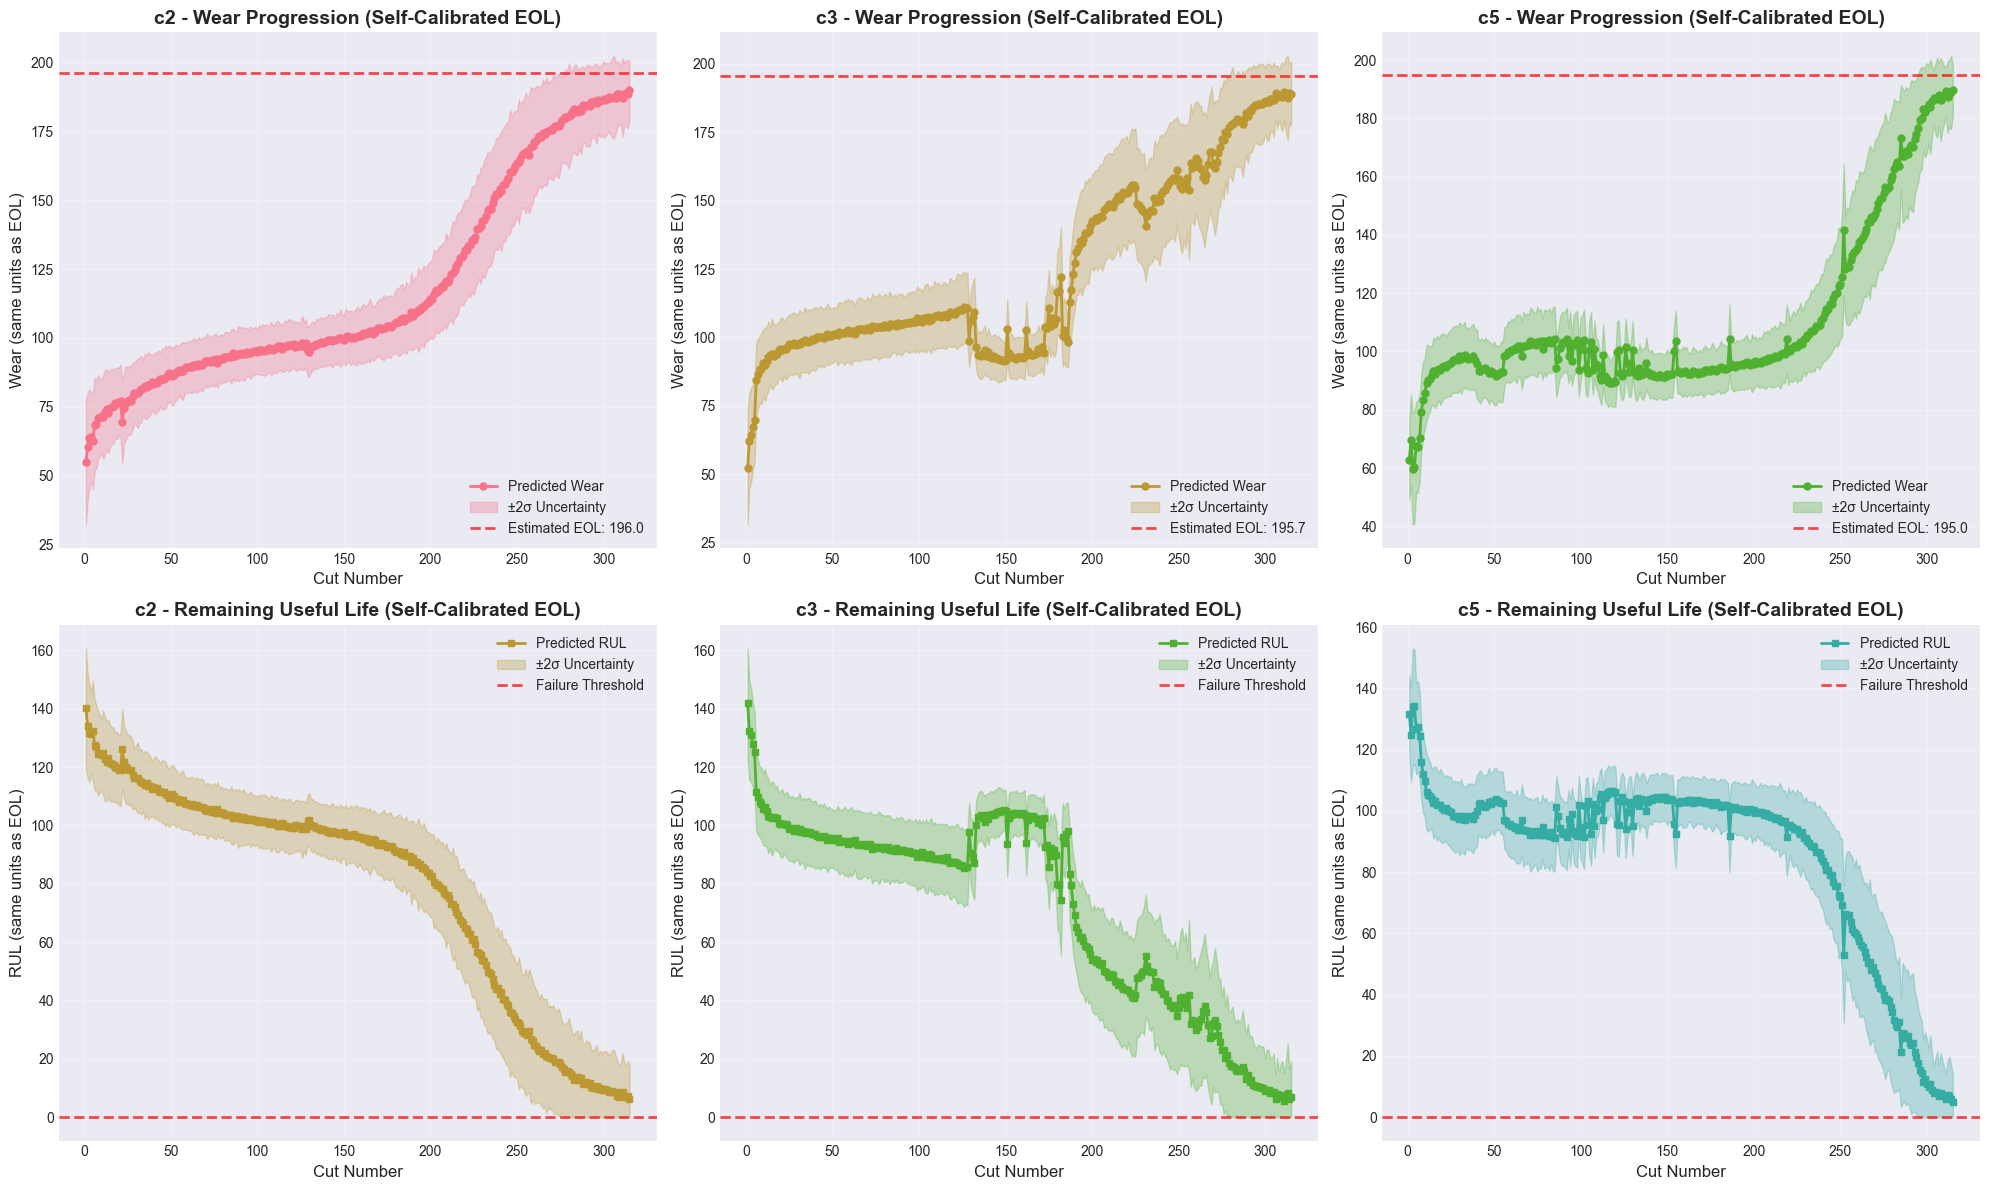

✅ Test trajectories plot saved as 'test_trajectories_selfcalibrated.png'


In [19]:
# ============================================================================
# CELL 19: Test Set Visualizations (Wear & RUL with Uncertainty)
# ============================================================================

COLOR_CYCLE = plt.rcParams["axes.prop_cycle"].by_key().get("color", ["C0", "C1", "C2", "C3"])

def plot_test_trajectories(test_df, test_cutters=TEST_CUTTERS, title_suffix=" (Self-Calibrated EOL)"):
    """
    Plot wear and RUL trajectories with ±2σ uncertainty for each test cutter.
    """
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()

    for idx, cutter_name in enumerate(test_cutters):
        df_c = test_df[test_df["cutter"] == cutter_name]
        if df_c.empty:
            continue

        df_c = df_c.sort_values("cut_number")
        x = df_c["cut_number"].values
        e_est = df_c["estimated_eol"].iloc[0]

        # --- Wear ---
        ax_wear = axes[idx]
        wear_pred = df_c["wear_pred"].values
        wear_std  = df_c["wear_std"].values

        ax_wear.plot(x, wear_pred, "o-", label="Predicted Wear",
                     color=COLOR_CYCLE[idx % len(COLOR_CYCLE)], linewidth=2, markersize=5)
        ax_wear.fill_between(
            x,
            np.maximum(wear_pred - 2 * wear_std, 0),
            wear_pred + 2 * wear_std,
            alpha=0.3,
            color=COLOR_CYCLE[idx % len(COLOR_CYCLE)],
            label="±2σ Uncertainty"
        )
        ax_wear.axhline(
            y=e_est,
            color="red", linestyle="--", linewidth=2,
            label=f"Estimated EOL: {e_est:.1f}",
            alpha=0.7
        )
        ax_wear.set_xlabel("Cut Number", fontsize=12)
        ax_wear.set_ylabel("Wear (same units as EOL)", fontsize=12)
        ax_wear.set_title(f"{cutter_name} - Wear Progression{title_suffix}", fontsize=14, fontweight="bold")
        ax_wear.legend()
        ax_wear.grid(True, alpha=0.3)

        # --- RUL ---
        ax_rul = axes[idx + 3]
        rul_pred = df_c["rul_pred"].values
        rul_std  = df_c["rul_std"].values

        ax_rul.plot(x, rul_pred, "s-", label="Predicted RUL",
                    color=COLOR_CYCLE[(idx + 1) % len(COLOR_CYCLE)], linewidth=2, markersize=5)
        ax_rul.fill_between(
            x,
            np.maximum(rul_pred - 2 * rul_std, 0),
            rul_pred + 2 * rul_std,
            alpha=0.3,
            color=COLOR_CYCLE[(idx + 1) % len(COLOR_CYCLE)],
            label="±2σ Uncertainty"
        )
        ax_rul.axhline(
            y=0,
            color="red", linestyle="--", linewidth=2,
            label="Failure Threshold",
            alpha=0.7
        )
        ax_rul.set_xlabel("Cut Number", fontsize=12)
        ax_rul.set_ylabel("RUL (same units as EOL)", fontsize=12)
        ax_rul.set_title(f"{cutter_name} - Remaining Useful Life{title_suffix}", fontsize=14, fontweight="bold")
        ax_rul.legend()
        ax_rul.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("test_trajectories_selfcalibrated.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("✅ Test trajectories plot saved as 'test_trajectories_selfcalibrated.png'")


# Call the plotting function
plot_test_trajectories(test_seq_predictions)


In [20]:
# ============================================================================
# CELL 20: Prepare Validation Predictions in Raw Units
# ============================================================================

# Copy to avoid modifying original
val_df = val_seq_predictions.copy()

# Map each cutter to its true EOL from training set
val_df["eol"] = val_df["cutter"].map(train_eols)

# Convert normalized predictions/std to raw units (same units as wear/RUL targets)
val_df["wear_pred"] = val_df["wear_pred_norm"] * val_df["eol"]
val_df["wear_std"]  = val_df["wear_std_norm"]  * val_df["eol"]
val_df["rul_pred"]  = val_df["rul_pred_norm"]  * val_df["eol"]
val_df["rul_std"]   = val_df["rul_std_norm"]   * val_df["eol"]

print("✅ Validation dataframe with raw units ready! Columns:")
print(val_df.columns.tolist())

# Optionally save
val_df.to_csv("val_predictions_mc_raw.csv", index=False)
print("💾 Saved 'val_predictions_mc_raw.csv'")


✅ Validation dataframe with raw units ready! Columns:
['cutter', 'cut_number', 'wear_pred_norm', 'wear_std_norm', 'rul_pred_norm', 'rul_std_norm', 'wear_true', 'rul_true', 'eol', 'wear_pred', 'wear_std', 'rul_pred', 'rul_std']
💾 Saved 'val_predictions_mc_raw.csv'


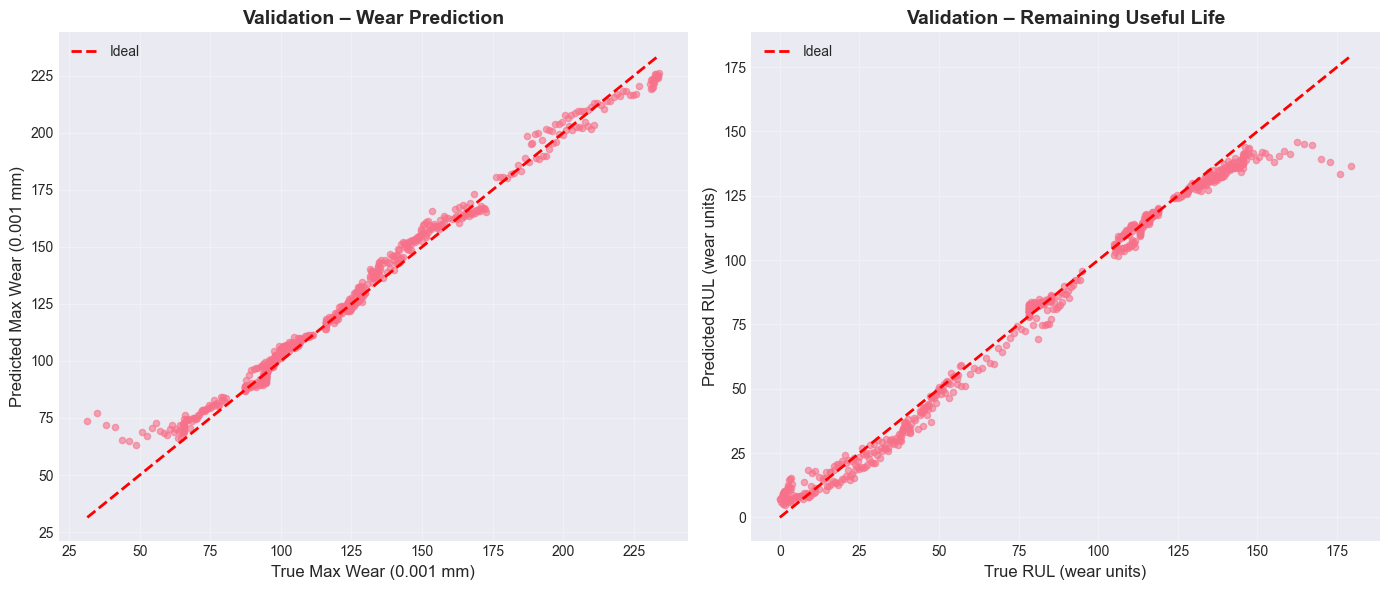

✅ Saved scatter plots as 'val_scatter_wear_rul.png'


In [21]:
# ============================================================================
# CELL 21: Validation Scatter Plots (Pred vs True)
# ============================================================================

def scatter_with_identity(ax, y_true, y_pred, title, xlabel, ylabel):
    ax.scatter(y_true, y_pred, alpha=0.6, s=20)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=2, label="Ideal")
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.grid(True, alpha=0.3)
    ax.legend()


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Wear
mask_w = val_df["wear_true"].notna()
scatter_with_identity(
    axes[0],
    val_df.loc[mask_w, "wear_true"].values,
    val_df.loc[mask_w, "wear_pred"].values,
    "Validation – Wear Prediction",
    "True Max Wear (0.001 mm)",
    "Predicted Max Wear (0.001 mm)"
)

# RUL
mask_r = val_df["rul_true"].notna()
scatter_with_identity(
    axes[1],
    val_df.loc[mask_r, "rul_true"].values,
    val_df.loc[mask_r, "rul_pred"].values,
    "Validation – Remaining Useful Life",
    "True RUL (wear units)",
    "Predicted RUL (wear units)"
)

plt.tight_layout()
plt.savefig("val_scatter_wear_rul.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅ Saved scatter plots as 'val_scatter_wear_rul.png'")


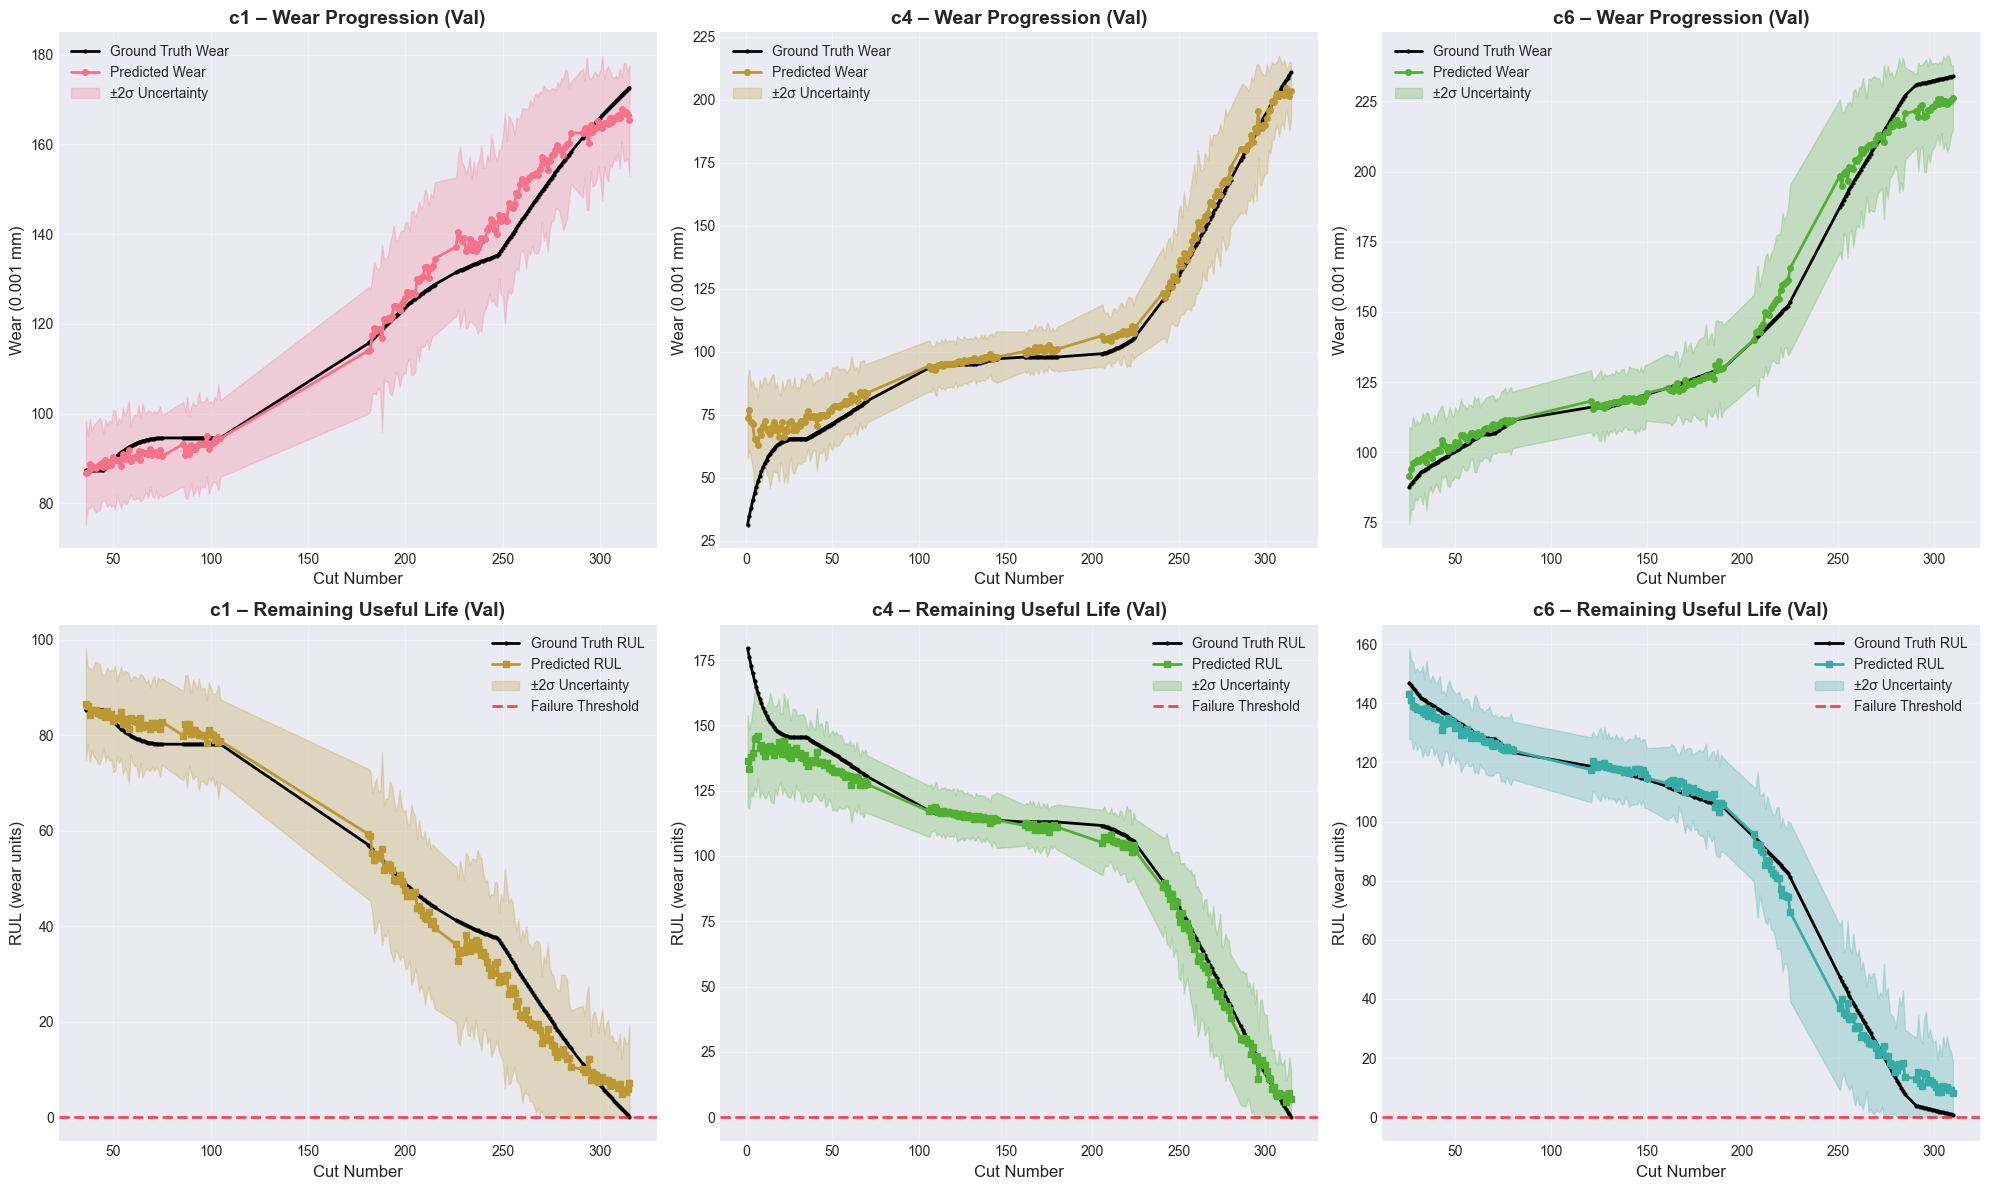

✅ Saved validation cutter curves as 'val_cutter_curves_wear_rul.png'


In [22]:
# ============================================================================
# CELL 22: Validation Curves per Training Cutter (Wear & RUL with Uncertainty)
# ============================================================================

VAL_CUTTERS = sorted(val_df["cutter"].unique())  # typically ['c1','c4','c6']

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, cutter_name in enumerate(VAL_CUTTERS):
    df_c = val_df[val_df["cutter"] == cutter_name].sort_values("cut_number")
    if df_c.empty:
        continue

    x = df_c["cut_number"].values

    # --- Wear ---
    ax_w = axes[idx]
    wear_true = df_c["wear_true"].values
    wear_pred = df_c["wear_pred"].values
    wear_std  = df_c["wear_std"].values

    ax_w.plot(x, wear_true, "k.-", label="Ground Truth Wear", linewidth=2, markersize=4)
    ax_w.plot(x, wear_pred, "o-", label="Predicted Wear",
              color=COLOR_CYCLE[idx % len(COLOR_CYCLE)], linewidth=2, markersize=4)
    ax_w.fill_between(
        x,
        np.maximum(wear_pred - 2 * wear_std, 0),
        wear_pred + 2 * wear_std,
        alpha=0.25,
        color=COLOR_CYCLE[idx % len(COLOR_CYCLE)],
        label="±2σ Uncertainty"
    )
    ax_w.set_xlabel("Cut Number", fontsize=12)
    ax_w.set_ylabel("Wear (0.001 mm)", fontsize=12)
    ax_w.set_title(f"{cutter_name} – Wear Progression (Val)", fontsize=14, fontweight="bold")
    ax_w.legend()
    ax_w.grid(True, alpha=0.3)

    # --- RUL ---
    ax_r = axes[idx + 3]
    rul_true = df_c["rul_true"].values
    rul_pred = df_c["rul_pred"].values
    rul_std  = df_c["rul_std"].values

    ax_r.plot(x, rul_true, "k.-", label="Ground Truth RUL", linewidth=2, markersize=4)
    ax_r.plot(x, rul_pred, "s-", label="Predicted RUL",
              color=COLOR_CYCLE[(idx + 1) % len(COLOR_CYCLE)], linewidth=2, markersize=4)
    ax_r.fill_between(
        x,
        np.maximum(rul_pred - 2 * rul_std, 0),
        rul_pred + 2 * rul_std,
        alpha=0.25,
        color=COLOR_CYCLE[(idx + 1) % len(COLOR_CYCLE)],
        label="±2σ Uncertainty"
    )
    ax_r.axhline(
        y=0,
        color="red", linestyle="--", linewidth=2,
        label="Failure Threshold", alpha=0.7
    )
    ax_r.set_xlabel("Cut Number", fontsize=12)
    ax_r.set_ylabel("RUL (wear units)", fontsize=12)
    ax_r.set_title(f"{cutter_name} – Remaining Useful Life (Val)", fontsize=14, fontweight="bold")
    ax_r.legend()
    ax_r.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("val_cutter_curves_wear_rul.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅ Saved validation cutter curves as 'val_cutter_curves_wear_rul.png'")


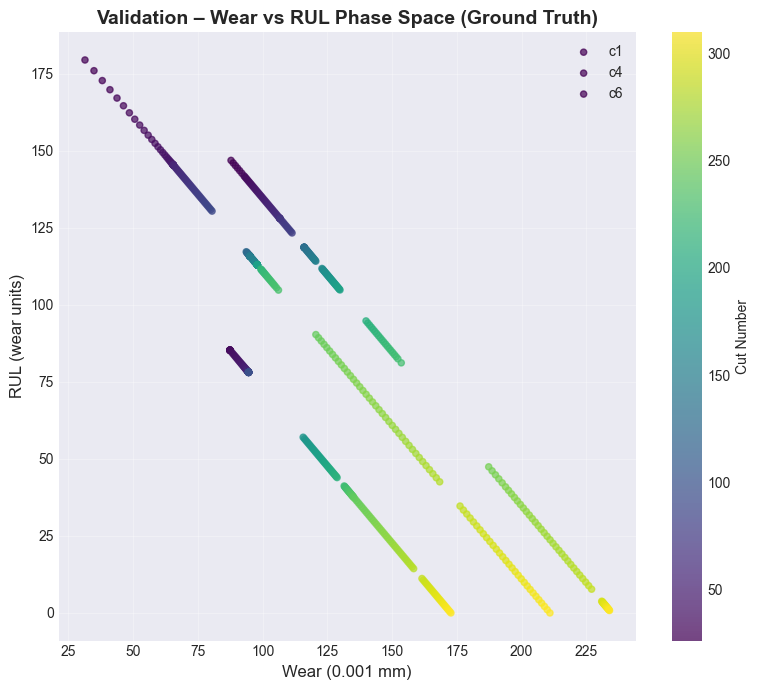

✅ Saved phase plot as 'val_phaseplot_wear_vs_rul.png'


In [23]:
# ============================================================================
# CELL 23: Wear–RUL Phase Plot for Validation Cutters
# ============================================================================

plt.figure(figsize=(8, 7))

for idx, cutter_name in enumerate(VAL_CUTTERS):
    df_c = val_df[val_df["cutter"] == cutter_name].sort_values("cut_number")
    if df_c.empty:
        continue

    wear_true = df_c["wear_true"].values
    rul_true  = df_c["rul_true"].values
    cuts      = df_c["cut_number"].values

    plt.scatter(
        wear_true, rul_true, s=20,
        c=cuts, cmap="viridis", alpha=0.7,
        label=f"{cutter_name}"
    )

cbar = plt.colorbar()
cbar.set_label("Cut Number")

plt.xlabel("Wear (0.001 mm)", fontsize=12)
plt.ylabel("RUL (wear units)", fontsize=12)
plt.title("Validation – Wear vs RUL Phase Space (Ground Truth)", fontsize=14, fontweight="bold")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("val_phaseplot_wear_vs_rul.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅ Saved phase plot as 'val_phaseplot_wear_vs_rul.png'")
